In [1]:
import os
from scipy.stats import gaussian_kde

import cv2
import matplotlib.pyplot as plt

import numpy as np

In [2]:
def show(img):
    plt.figure(figsize=(20, 10))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
        
def plot_hor_lines(img, hor_lines):
    local_img = img.copy()
    for value in hor_lines:
        # cv2.line(local_img, (0, value), (local_img.shape[-1] - 1, value + 2,), (0, 255, 0) , 2)
        cv2.line(local_img, (0, value), (img.shape[1], value), (0, 255, 0) , 1)
    return local_img


def plot_ver_lines(img, ver_lines):
    local_img = img.copy()
    for value in ver_lines:
        cv2.line(local_img, (value, 0), (value, img.shape[1]), (0, 255, 0) , 2)
    return local_img

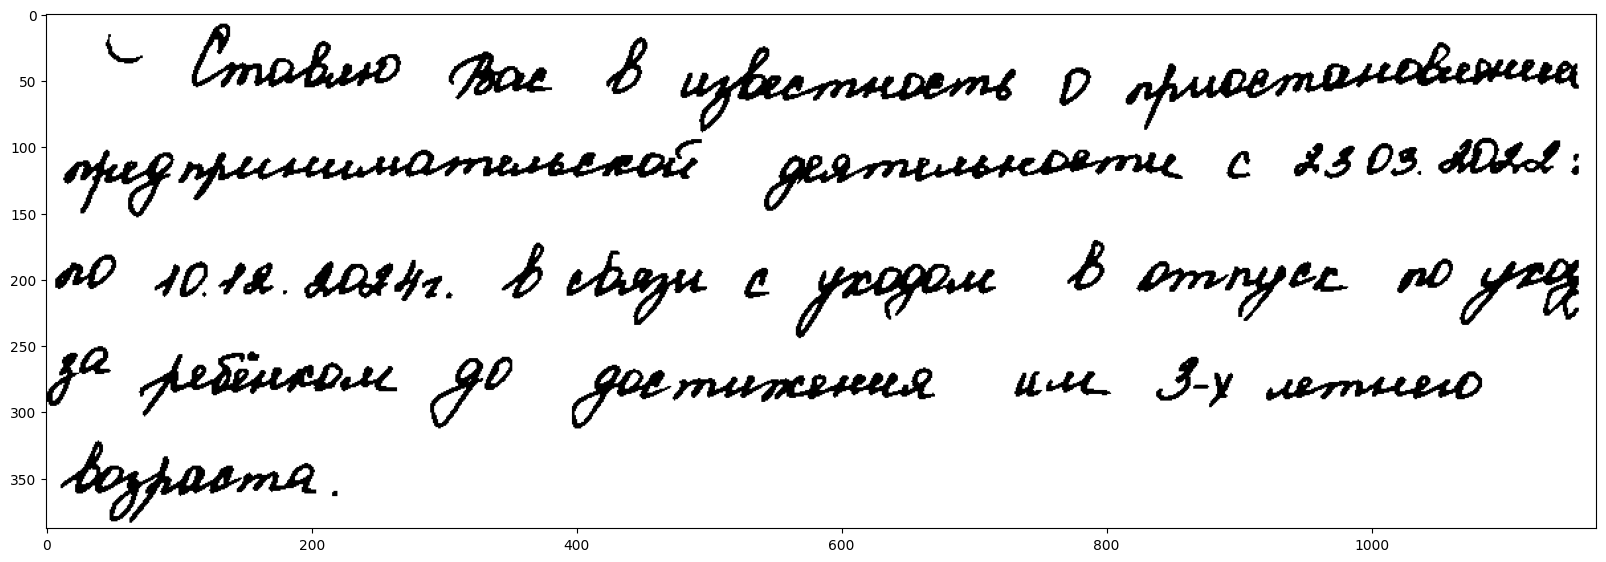

In [3]:
img = cv2.imread('test_image.png')


grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gaussianFilter = cv2.GaussianBlur(grayImage, (5, 5), 0)

_, binarizedImage = cv2.threshold(gaussianFilter, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


binarizedImage[binarizedImage == 0] = 0
binarizedImage[binarizedImage == 255] = 1

show(binarizedImage)

In [4]:
from scipy.signal import argrelextrema
import numpy as np

def find_local_maximals(arr, max_val):
    arr = np.array(arr)
    local_maxima_indices = argrelextrema(arr, np.greater)[0]
    local_maximals = list(zip(local_maxima_indices, arr[local_maxima_indices]))

    return [(int(item[0] * max_val / len(arr)), item[1]) for item in local_maximals]

#TODO: better handle for near lines
def find_dividers(img_path):
    img = cv2.imread(img_path)

    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gaussianFilter = cv2.GaussianBlur(grayImage, (5, 5), 0)

    _, binarizedImage = cv2.threshold(gaussianFilter, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    binarizedImage[binarizedImage == 0] = 0
    binarizedImage[binarizedImage == 255] = 1

    horizontal_projection = np.sum(binarizedImage, axis=1)

    data = []

    for i in range(len(horizontal_projection)):
        data.extend([i] * horizontal_projection[i])

    kde = gaussian_kde(data,  bw_method=0.05)
    x_values = np.linspace(np.min(data), np.max(data), 1000)

    y_values = kde(x_values)

    local_maxs = find_local_maximals(y_values, np.max(data))

    
    return [0] + [item[0] for item in local_maxs[1:-1]] + [img.shape[0] - 1]

# cv2.imwrite('./result/' + img_path.split('/')[-1], final)
#
# for path in tqdm(os.listdir('hand_written_descewed')):
#     find_lines('hand_written_cropped/' + path)

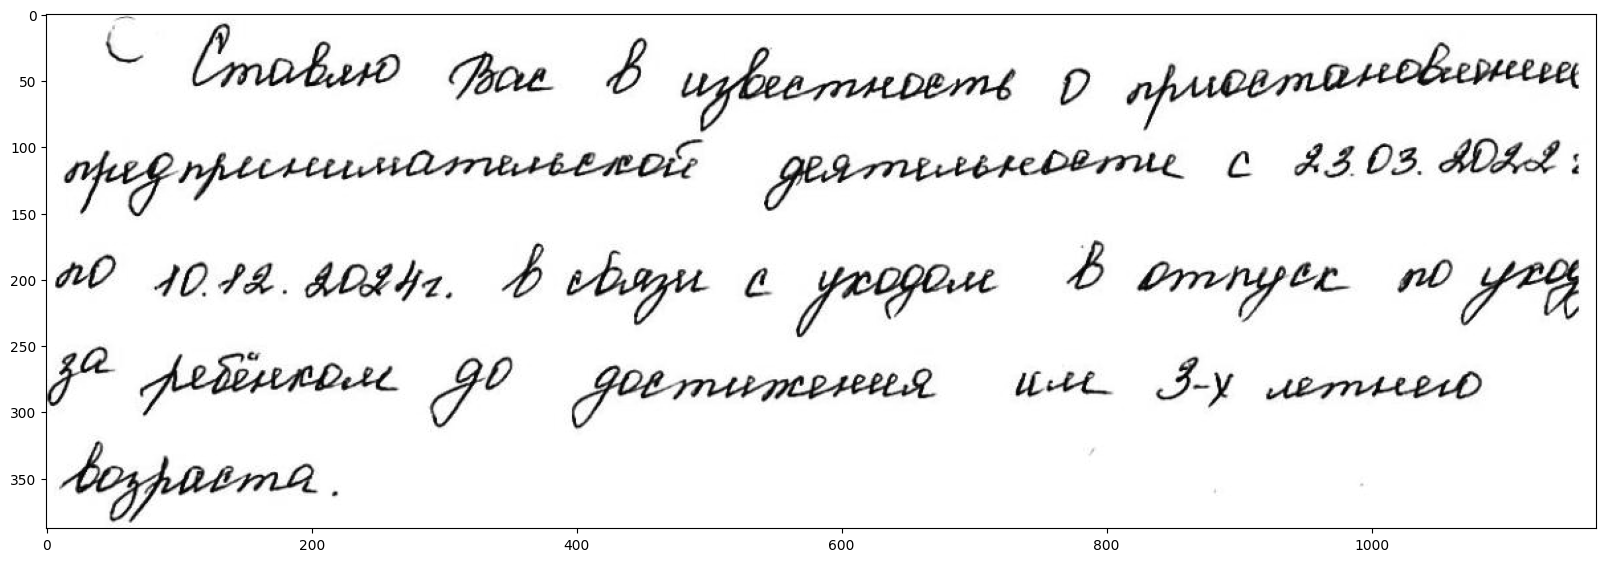

In [5]:
show(grayImage)

[0, 65, 125, 175, 227, 278, 331]


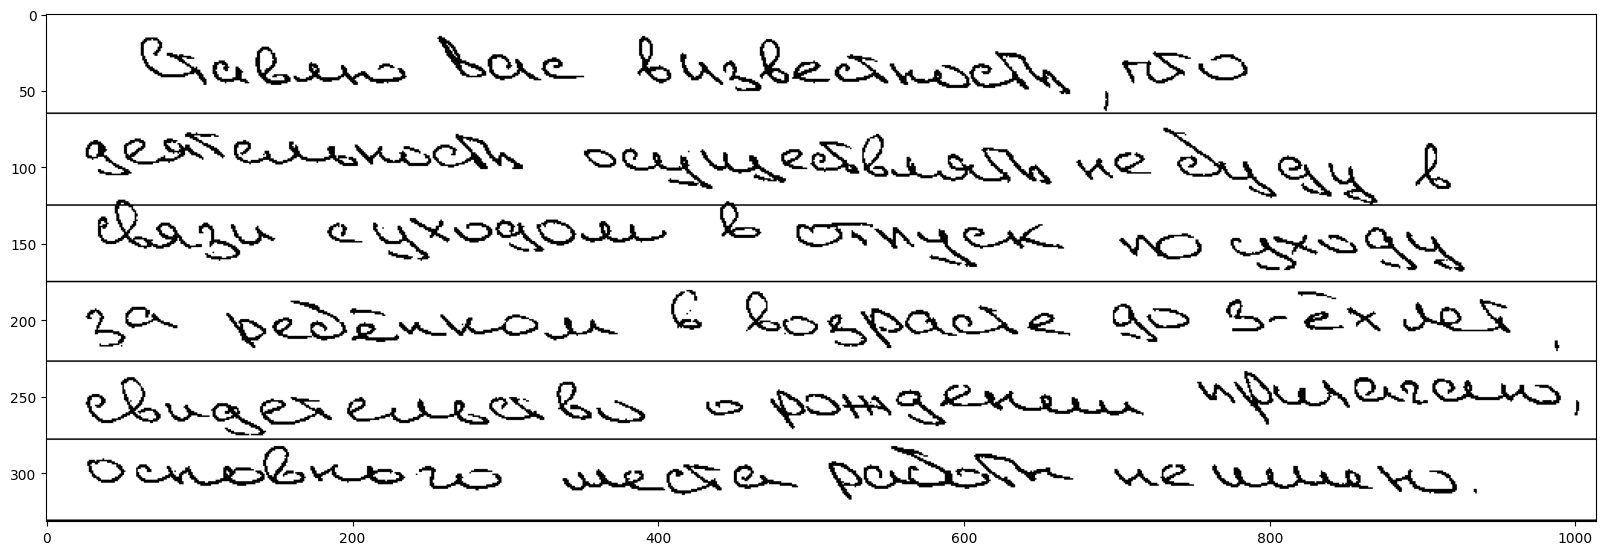

In [6]:
from tqdm.notebook import tqdm

path = 'hand_written_cropped/page_2.png'

img = cv2.imread(path)
grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gaussianFilter = cv2.GaussianBlur(grayImage, (5, 5), 0)
_, binarizedImage = cv2.threshold(grayImage, 235, 255, cv2.THRESH_BINARY)

binarizedImage[binarizedImage == 0] = 0
binarizedImage[binarizedImage == 255] = 1

lines = find_dividers(path)
print(lines)
final = plot_hor_lines(binarizedImage, lines)
show(final)

In [7]:
def get_text_line(bin_img, upper, lower, padding=100, relative_thr=0.7, component_len_thr=100):
    mask = bin_img[upper: lower, ...]
    # components2add = []
    # components2remove = []
    visited = set()
    for i in range(bin_img.shape[1]):
        if bin_img[upper][i] == 0 and (upper, i) not in visited:
            component = get_component_for_pix(bin_img, (upper, i), 100000, -100000)
            
            count_above = len(list(filter(lambda item: item[0] < upper, component)))
            count_below = len(component) - count_above
            visited.update(component)
            
            # if count_above > count_below:
            #     if (count_above - count_below) / len(component) > relative_thr:
            #         components2remove.append(component)
                    
            # if count_below > count_above and len(component) < component_len_thr:
            #     if (count_below - count_above) / len(component) > relative_thr:
            #         components2add.append(component)

            
            # if count_above < :
            #     components2add.append(component)
            # else:
            #     components2remove.append(component)

        if bin_img[lower][i] == 0 and (lower, i) not in visited:
            component = get_component_for_pix(bin_img, (lower, i), 100000, -100000)
            
            count_below = len(list(filter(lambda item: item[0] > lower, component)))
            count_above = len(component) - count_below
            visited.update(component)
            
            # if count_below > count_above:
            #     if (count_below - count_above) / len(component) > relative_thr:
            #         components2remove.append(component)
                    
            # if count_above > count_below and len(component) < component_len_thr:
            #     if (count_above - count_below) / len(component) > relative_thr:
            #         components2add.append(component)
            
            # if count_below < len(component) - count_below:
            #     components2add.append(component)
            # else:
            #     components2remove.append(component)

    padded_image = cv2.copyMakeBorder(mask, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=(1, 1, 1))

    # for component in components2add:
    #     for pixel in component:
    #         padded_image[(padding - (upper - pixel[0]), pixel[1])] = 0
    #         
    # for component in components2remove:
    #     for pixel in component:
    #         padded_image[(padding - (upper - pixel[0]), pixel[1])] = 1

    return padded_image

def get_component_for_pix(bin_img, start, upper, lower):
    component = []
    queue = [start]

    while len(queue) != 0:
        cur = queue[0]
        del queue[0]

        if cur not in component:
            component.append(cur)
            x, y = cur
            left = x, y - 1
            right = x, y + 1
            bottom = x + 1, y
            top = x - 1, y

            if left[1] >= 0 and bin_img[left] == 0:
                queue.append(left)
            if right[1] < bin_img.shape[1] and bin_img[right] == 0:
                queue.append(right)
            if top[0] >= 0 and (top[0] <= upper) and bin_img[top] == 0:
                queue.append(top)
            if bottom[0] < bin_img.shape[0] and (lower <= bottom[0]) and bin_img[bottom] == 0:
                queue.append(bottom)

    return component


248
238
243
235
245
265
260
250
252
251
253
266
254
270
256
249
245


/tmp/ipykernel_18462/3752440298.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 10))


268
250
255
246
248
258
268
260
268
274
295
260
263
256
267
281
277
281
278
269
278
274
267
265
252
286
264
267
261
266
274
262
258
257
269
247
237
236
238
245
238
270


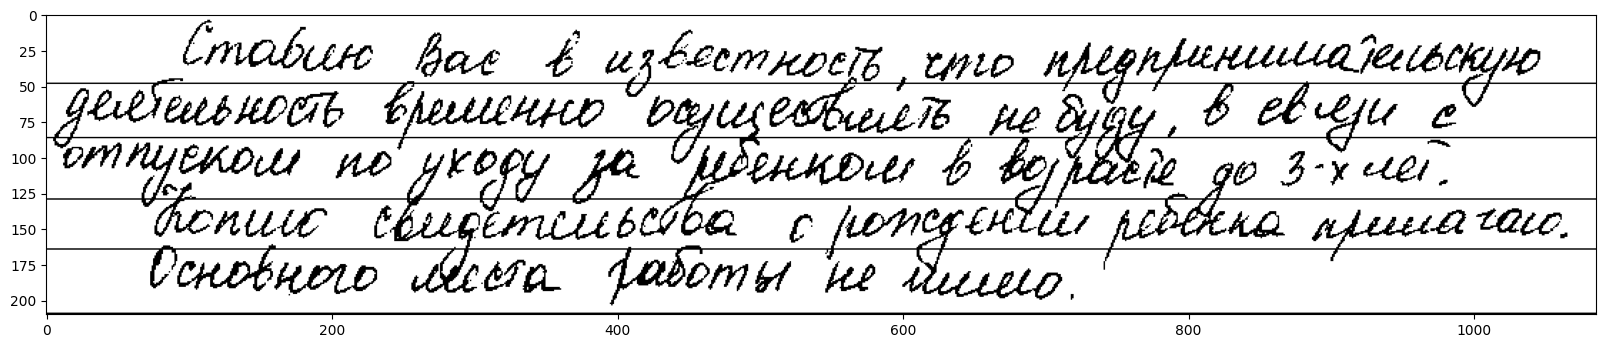

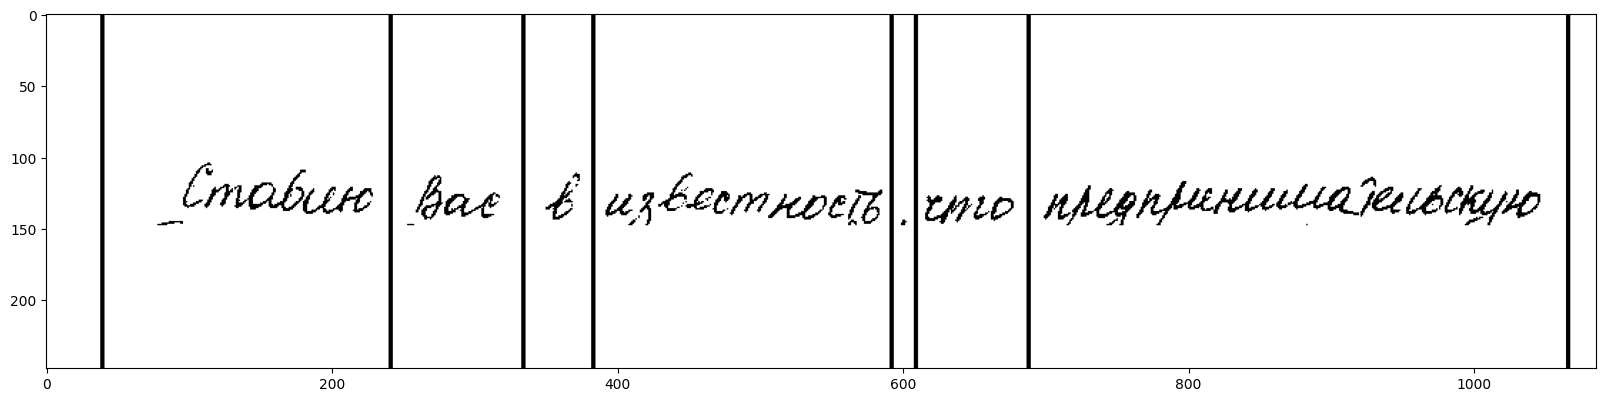

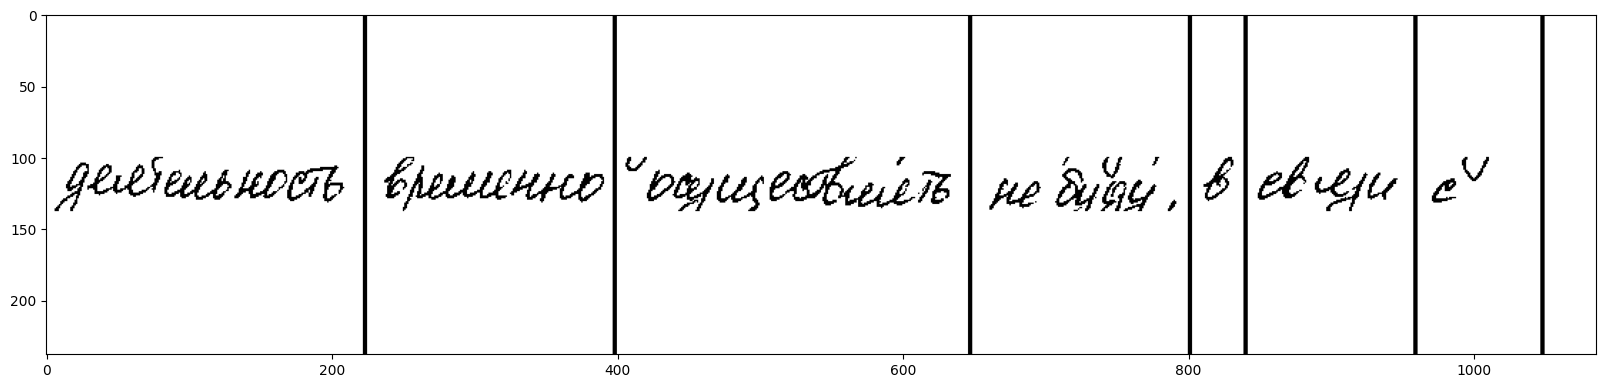

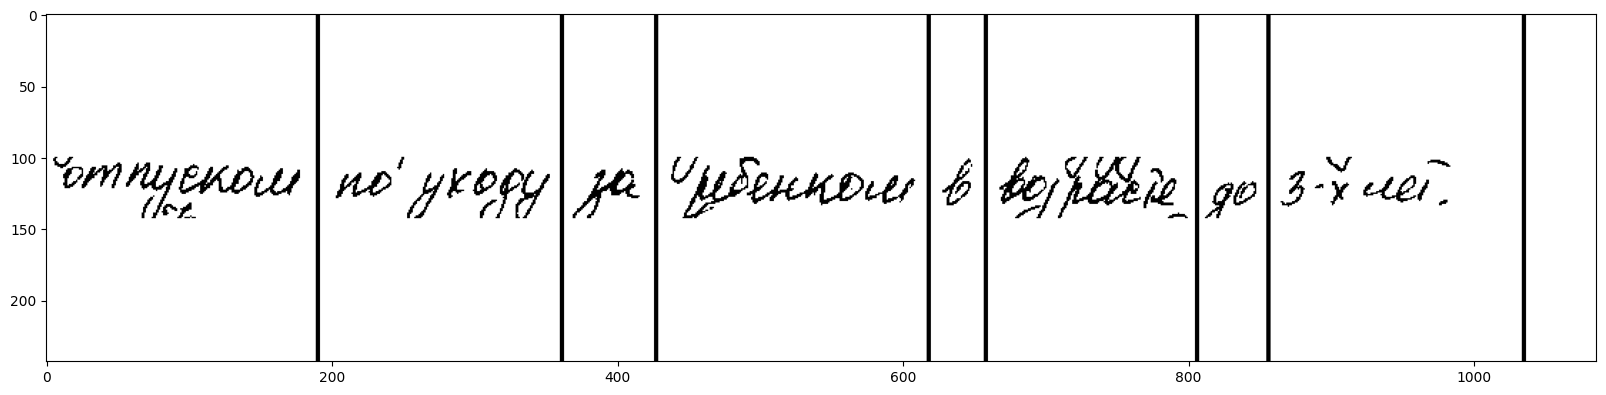

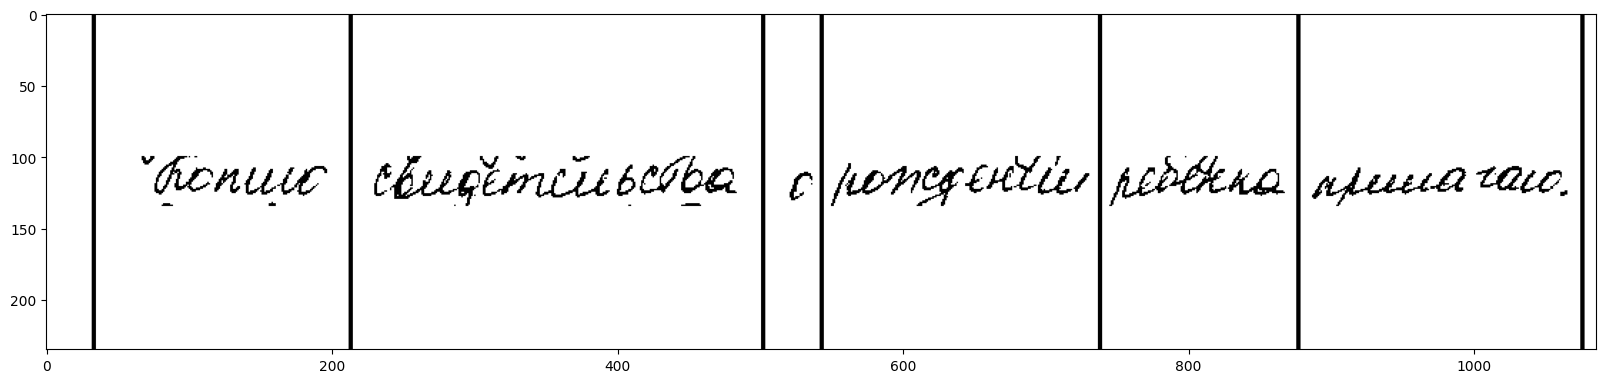

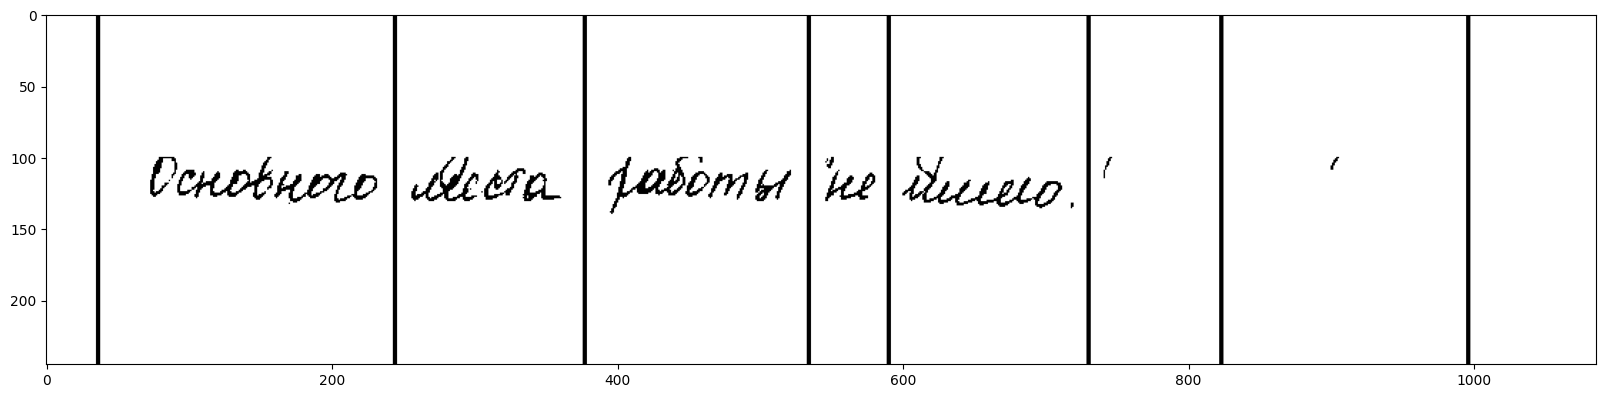

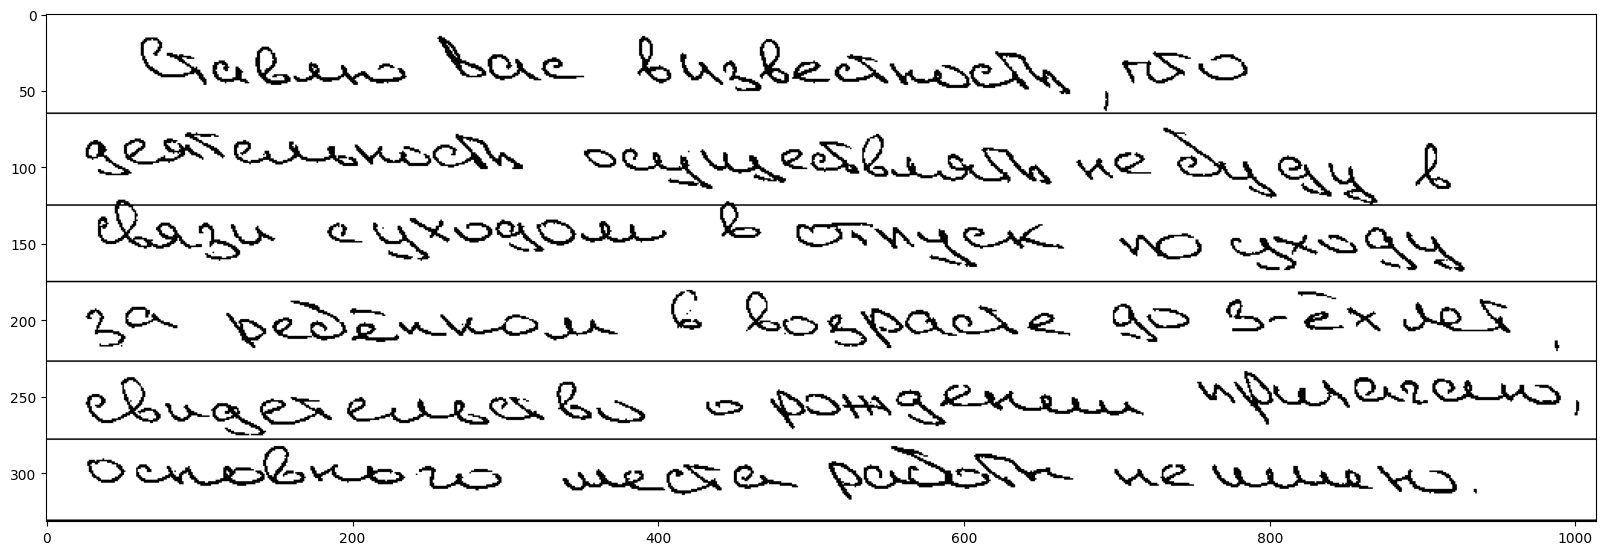

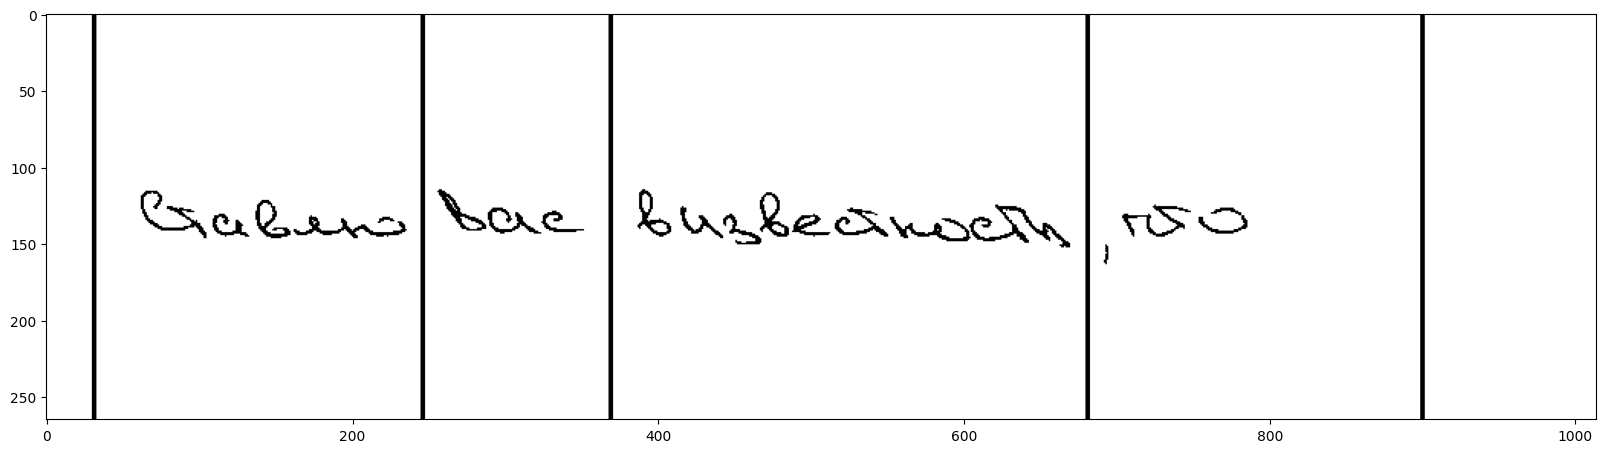

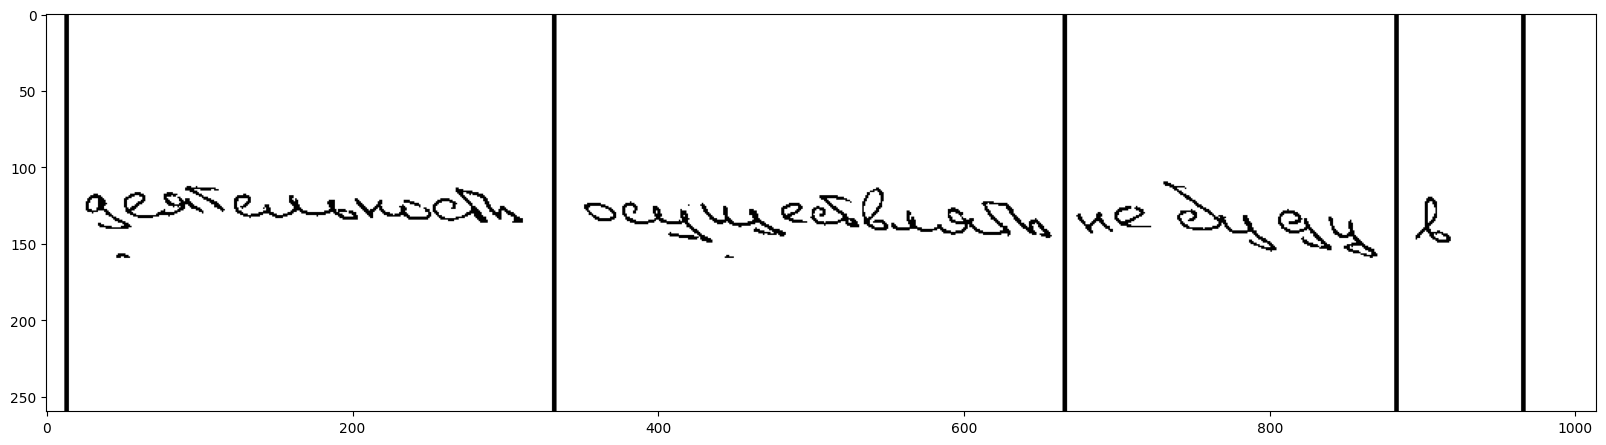

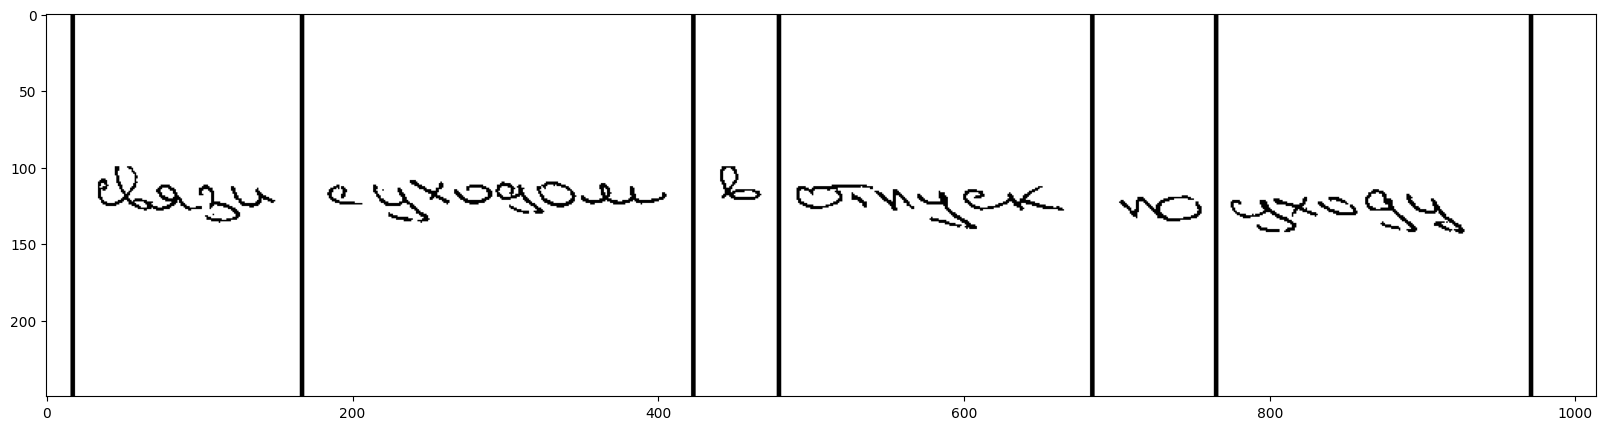

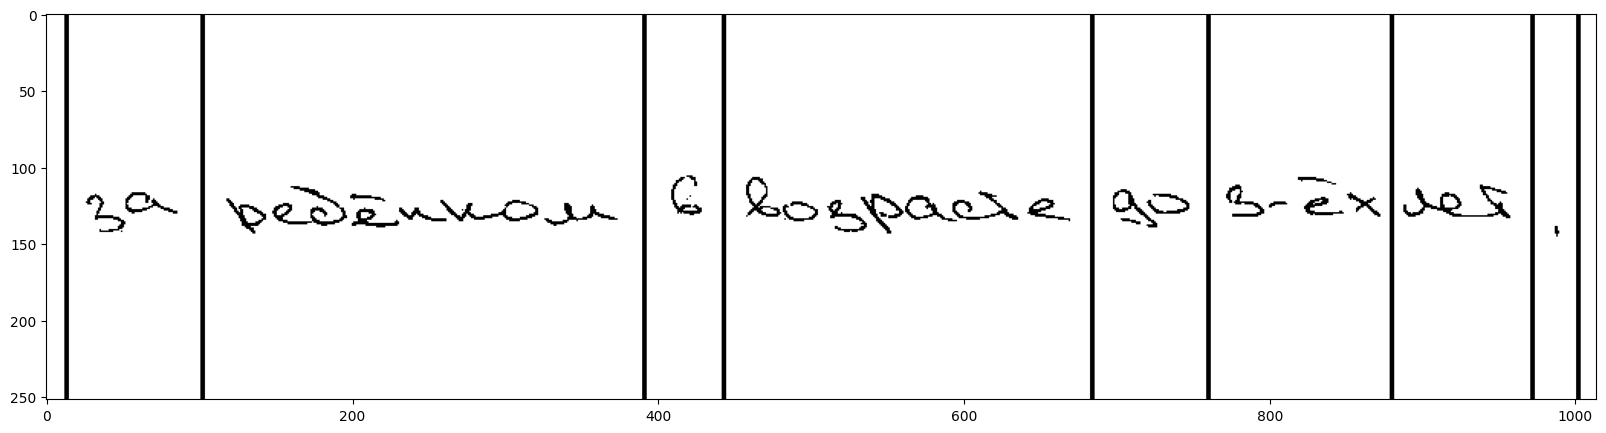

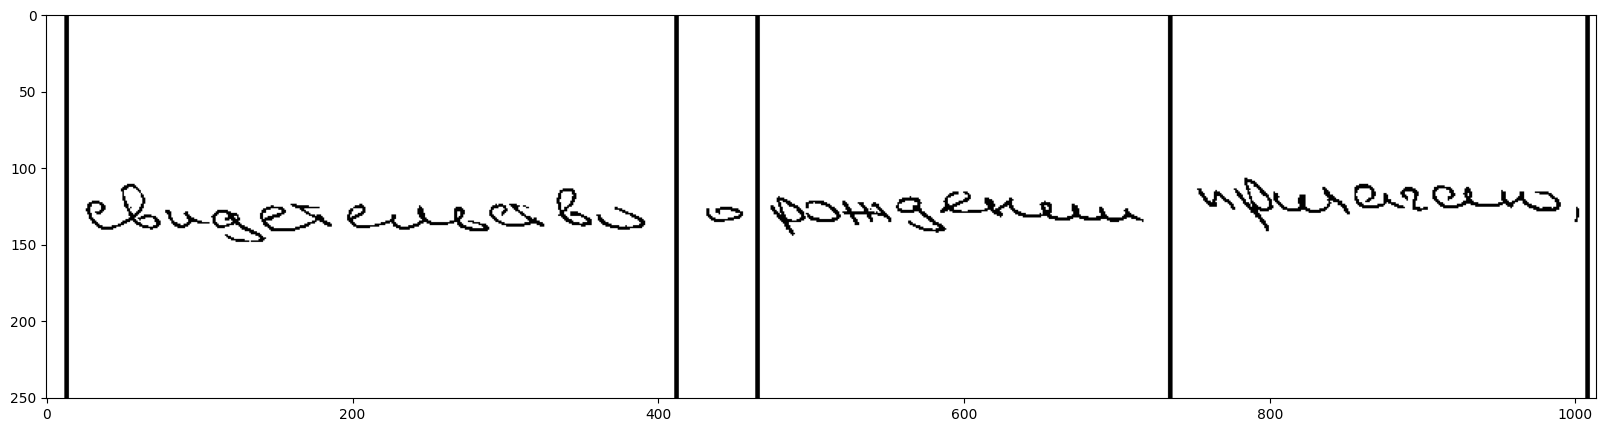

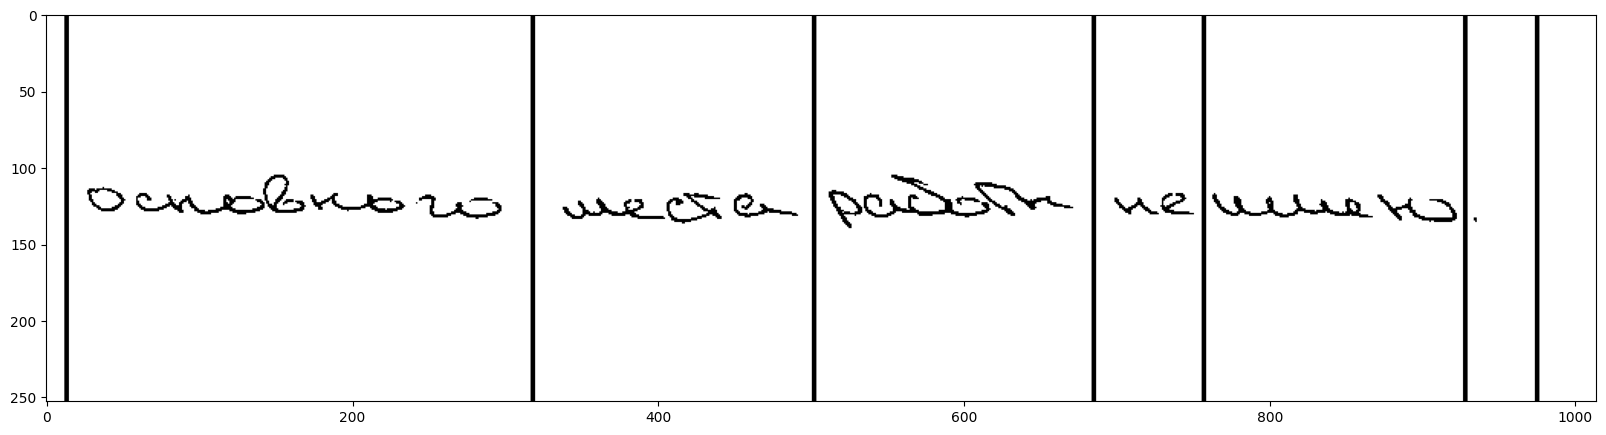

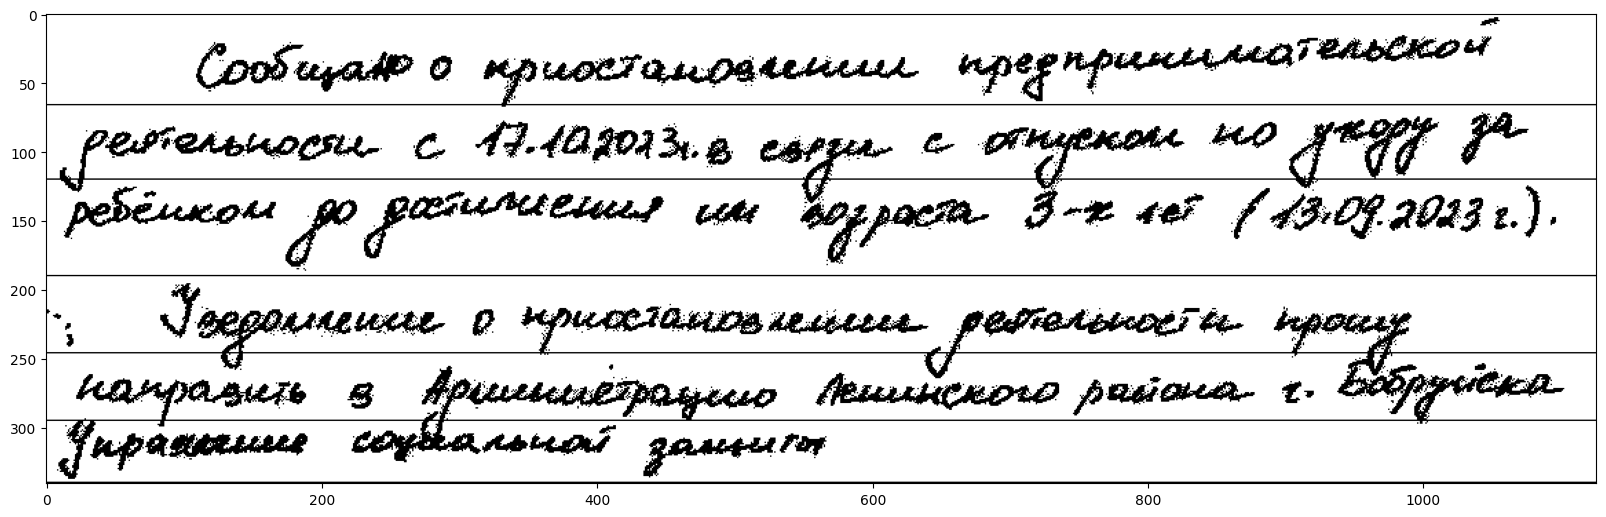

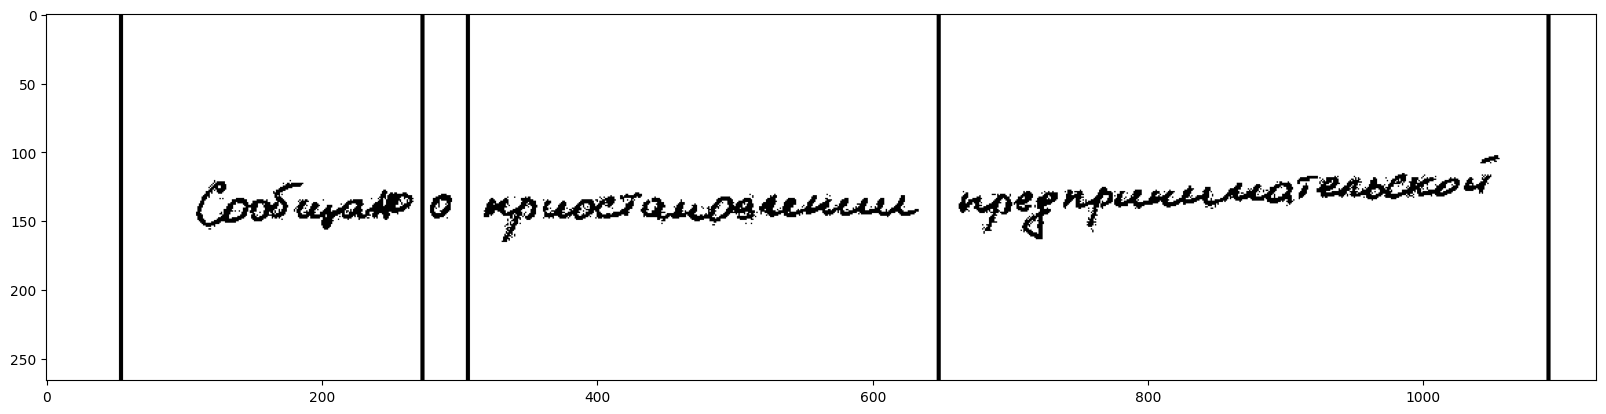

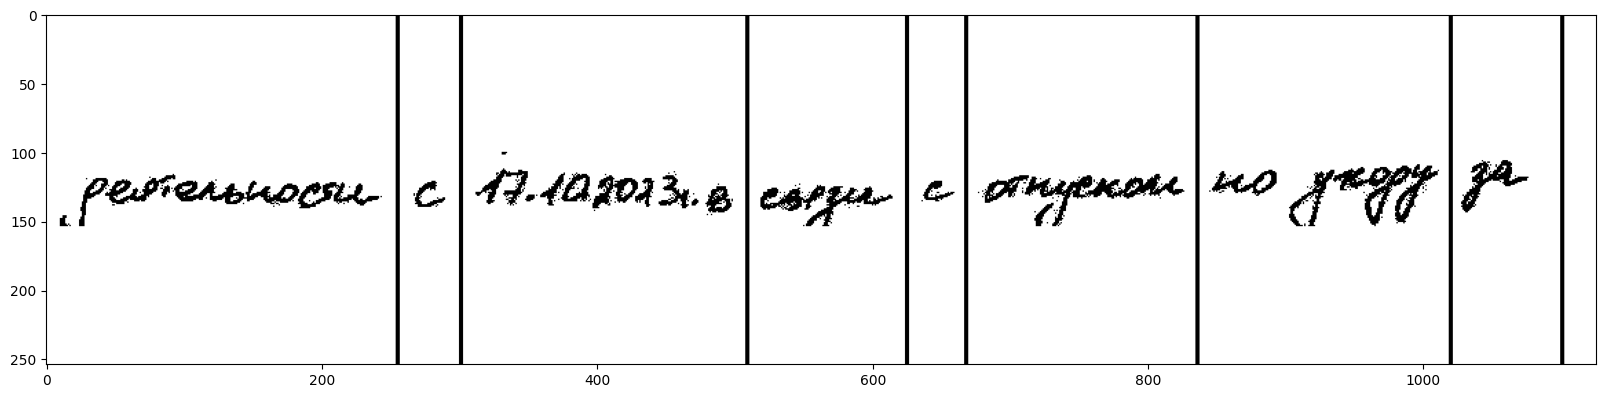

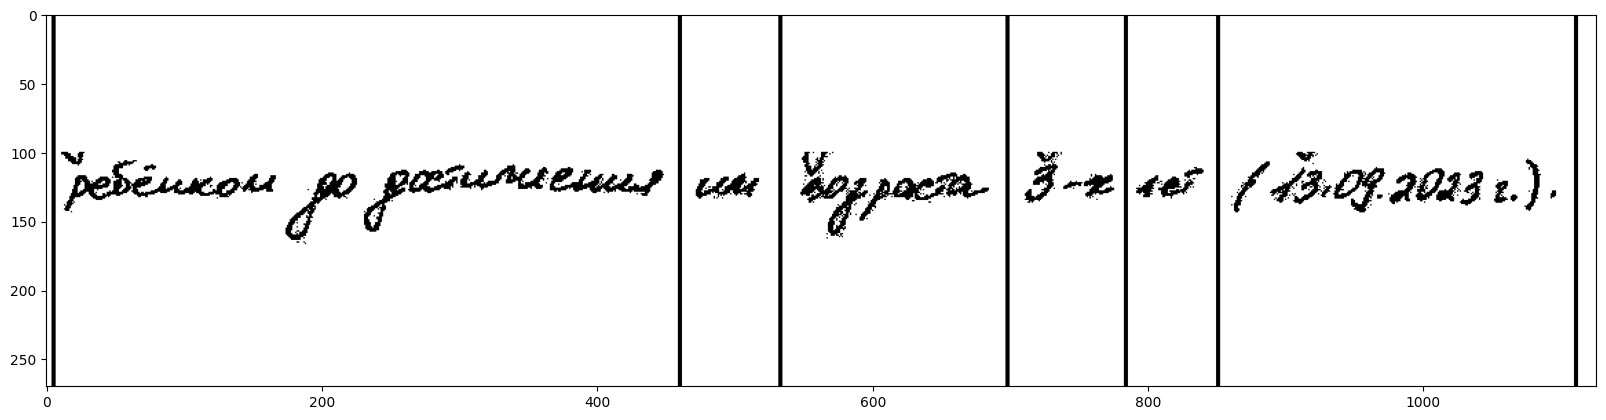

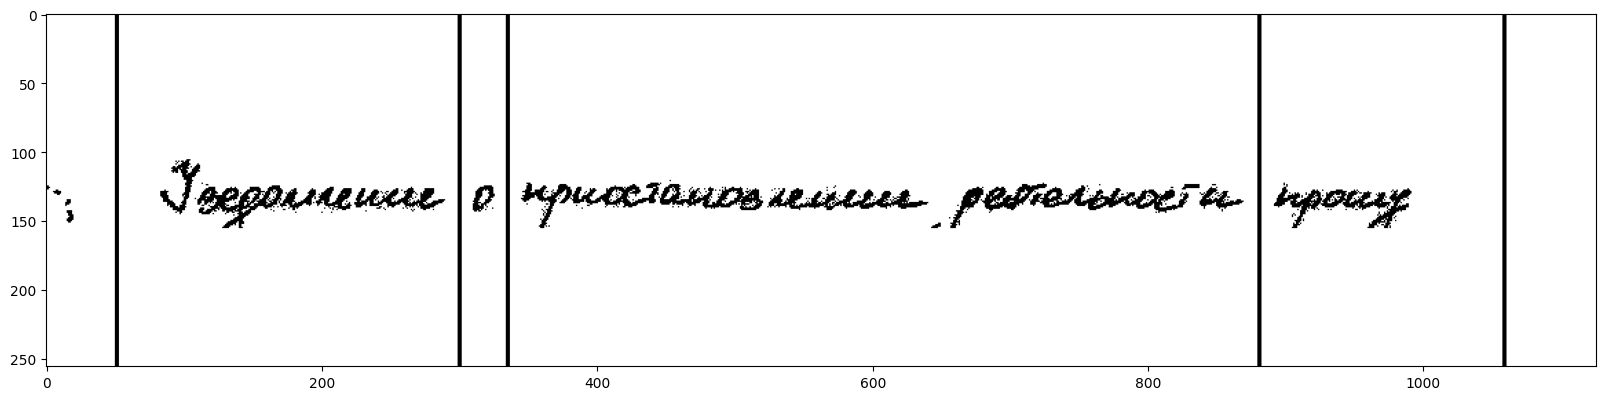

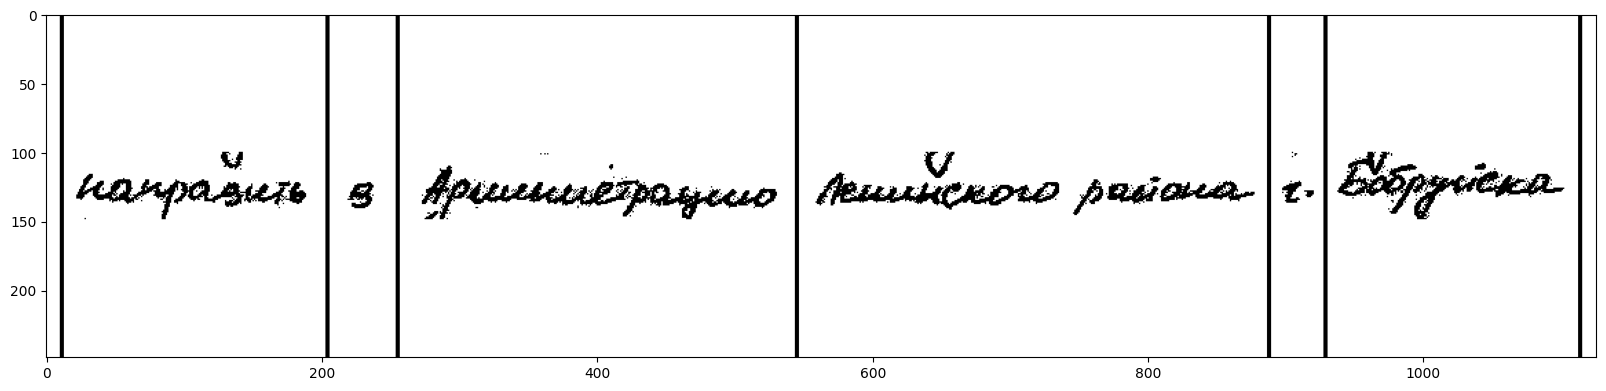

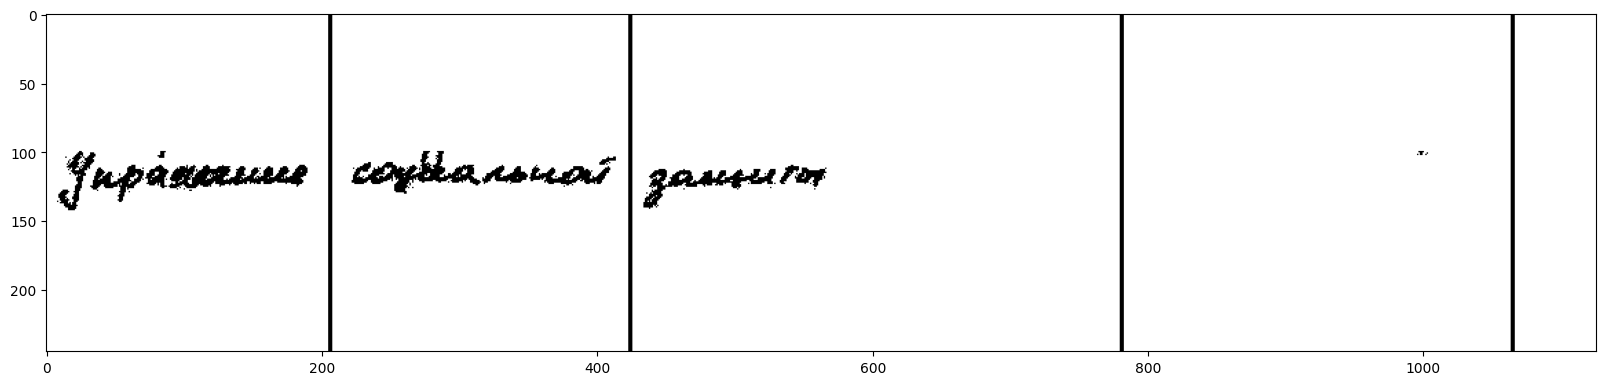

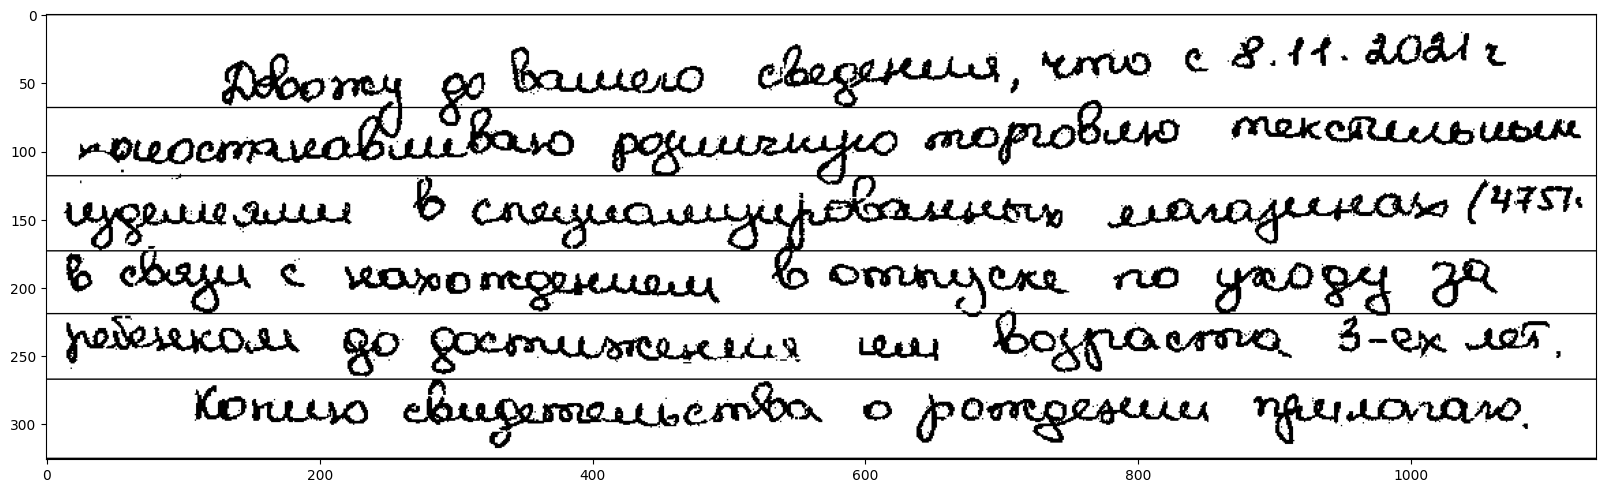

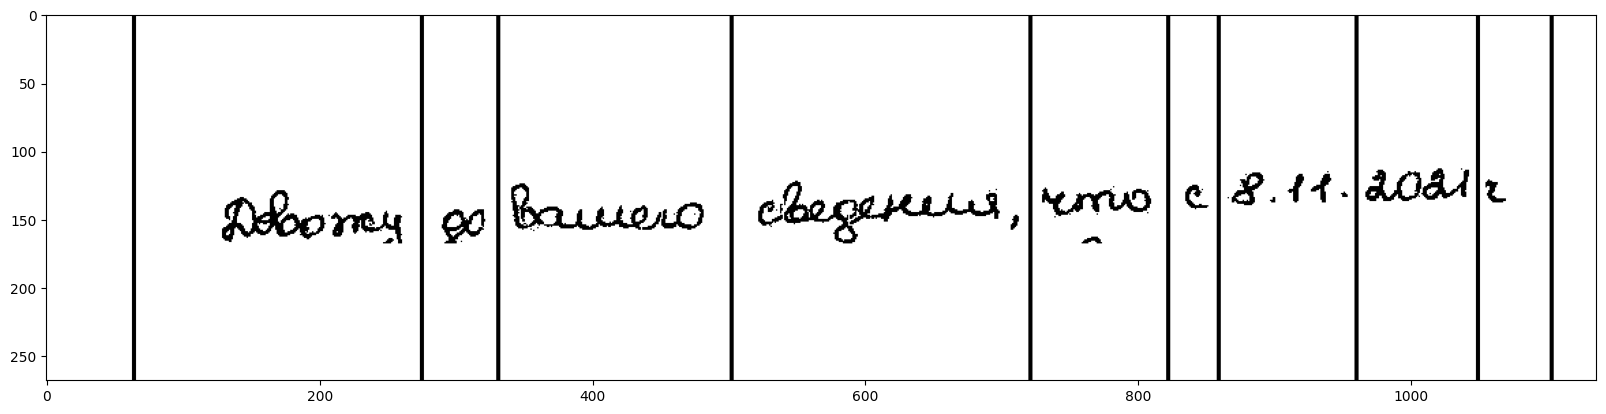

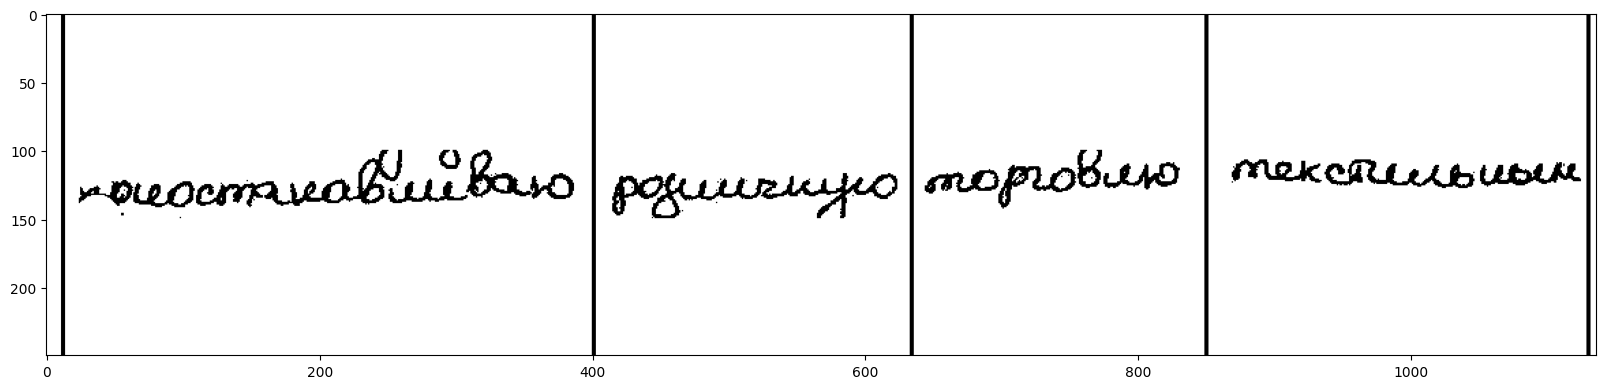

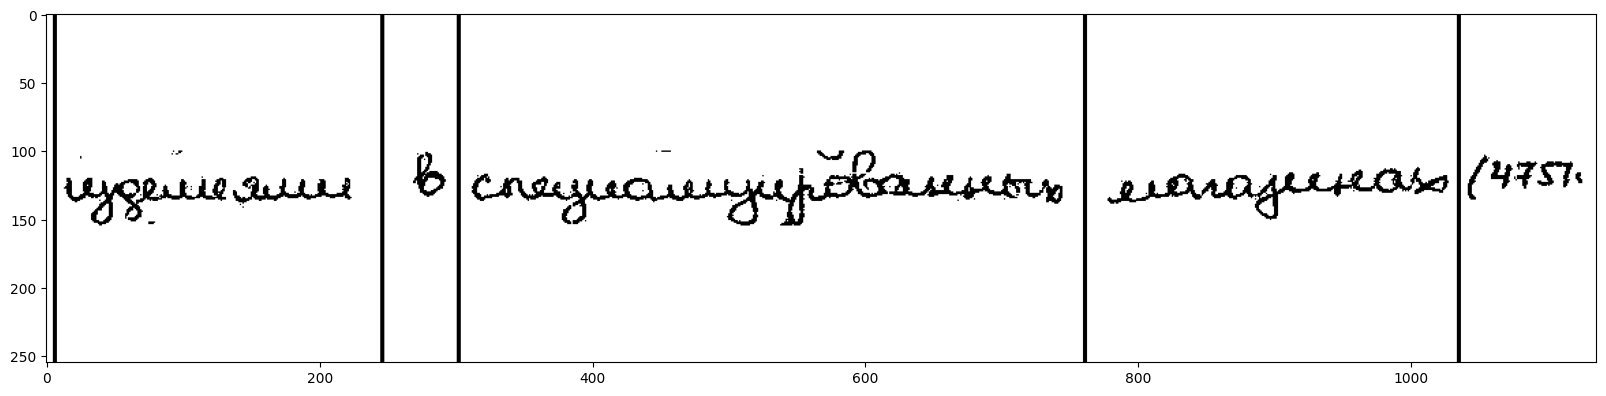

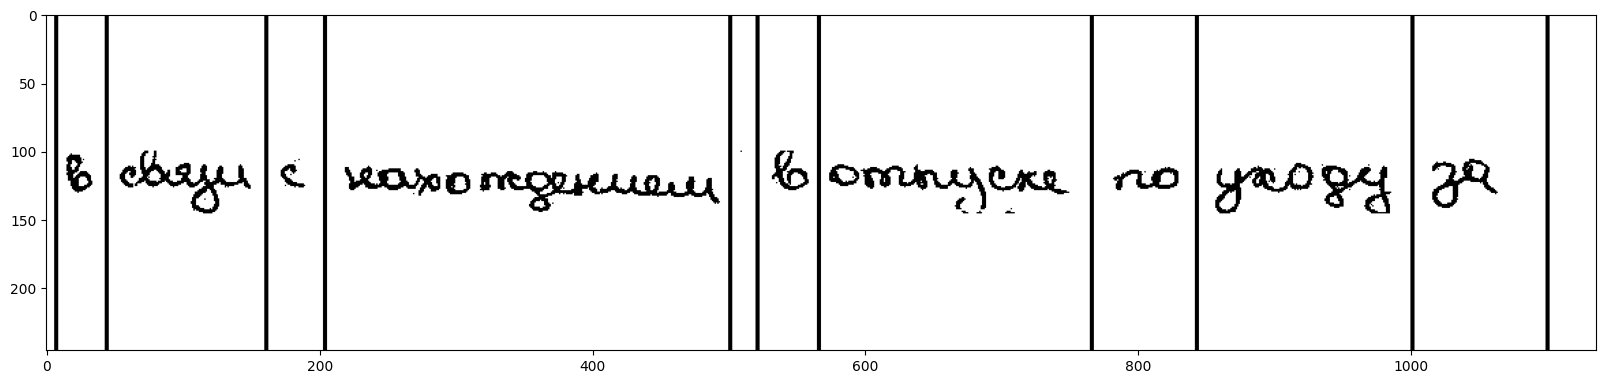

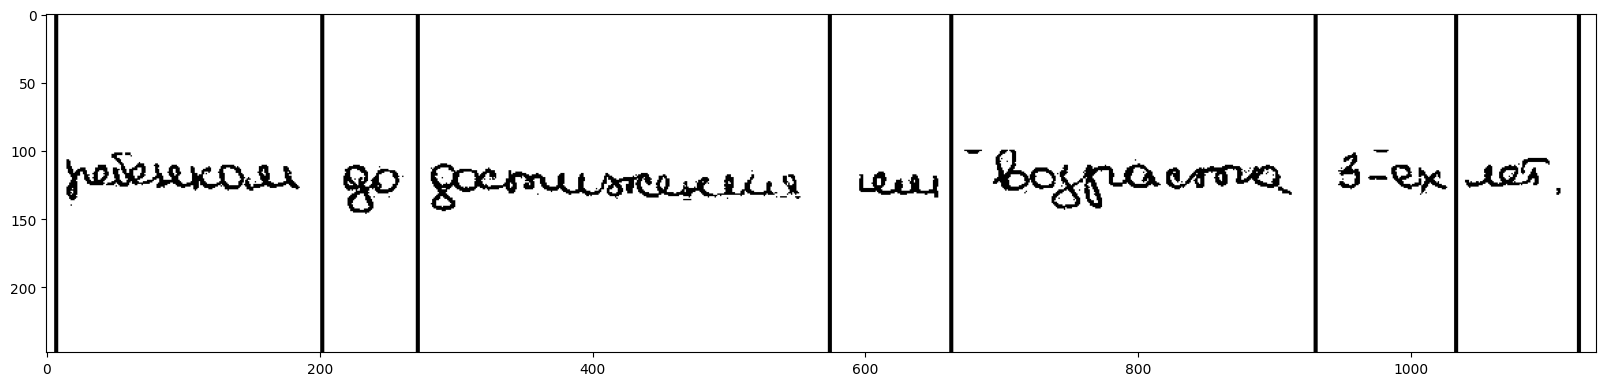

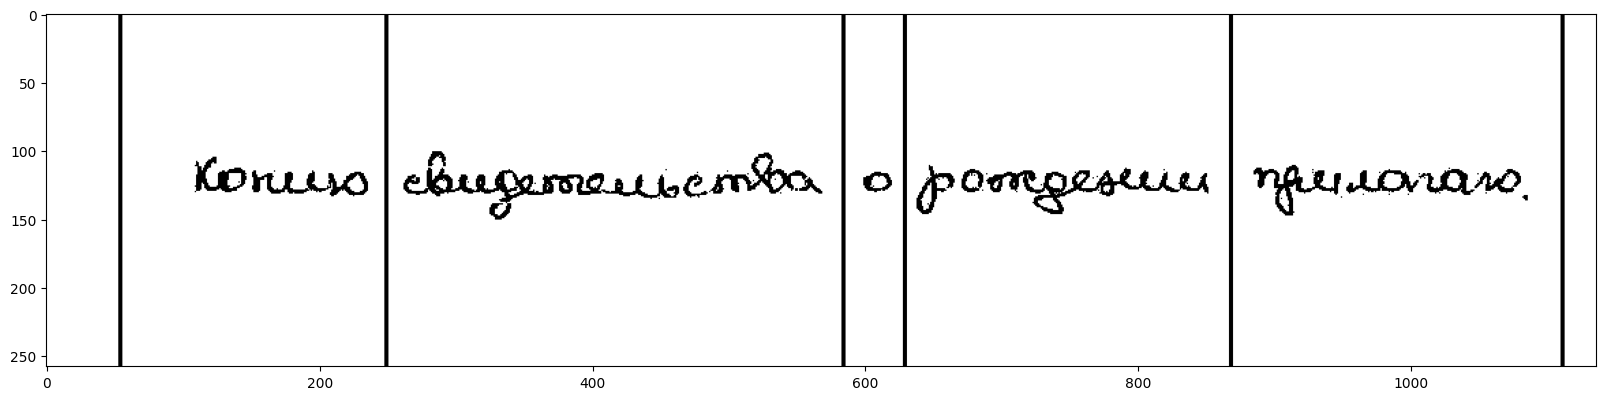

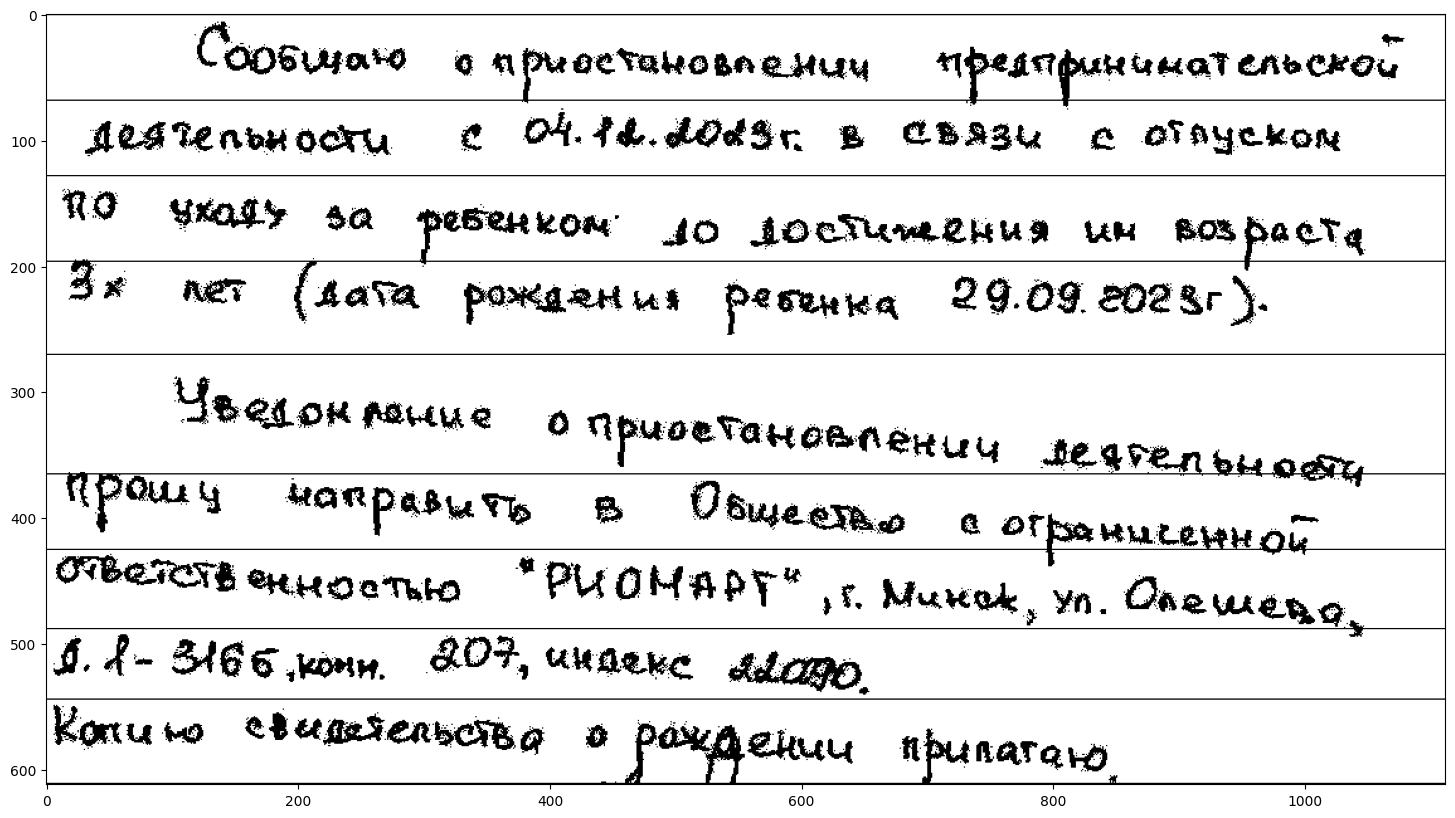

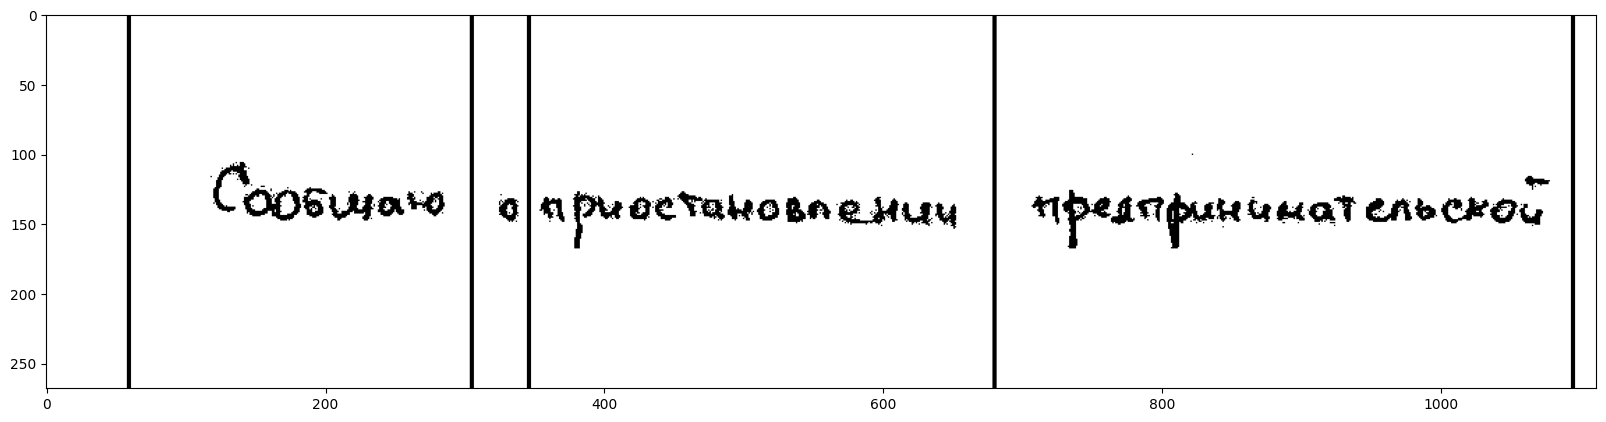

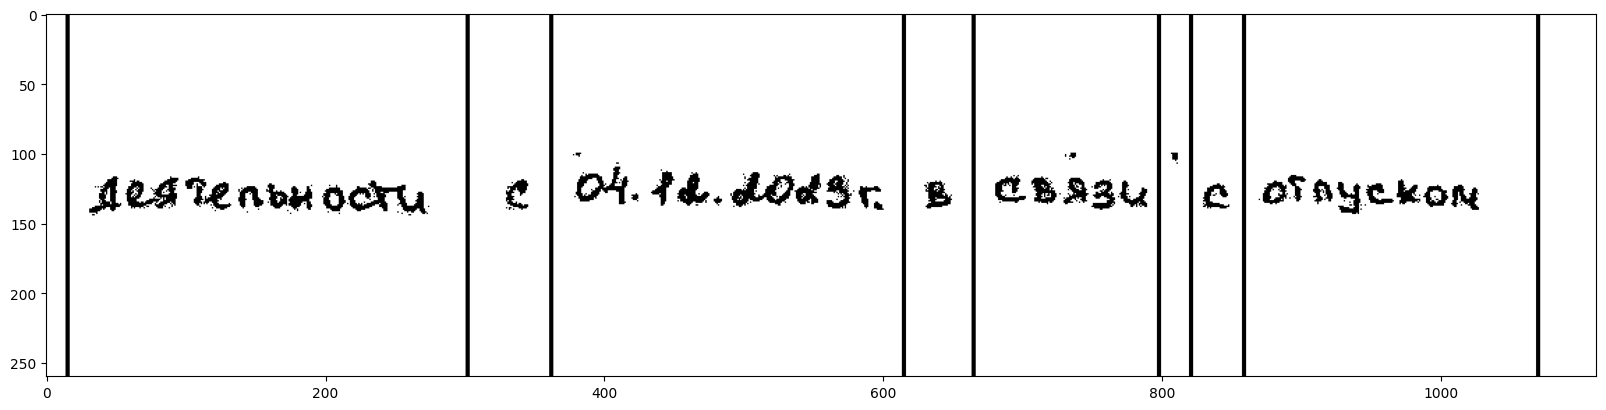

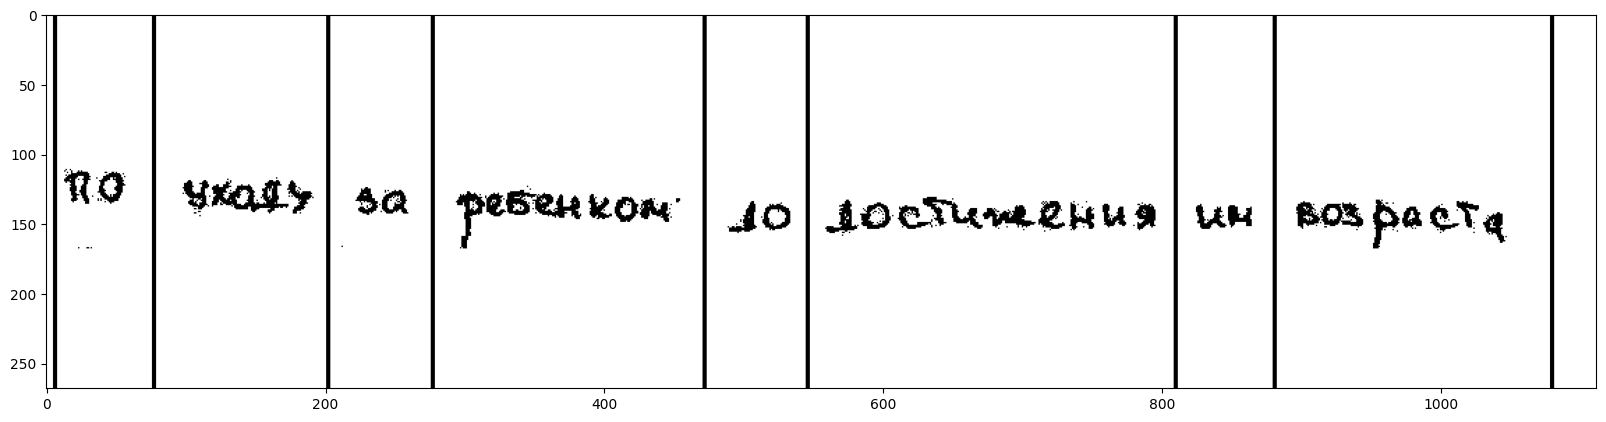

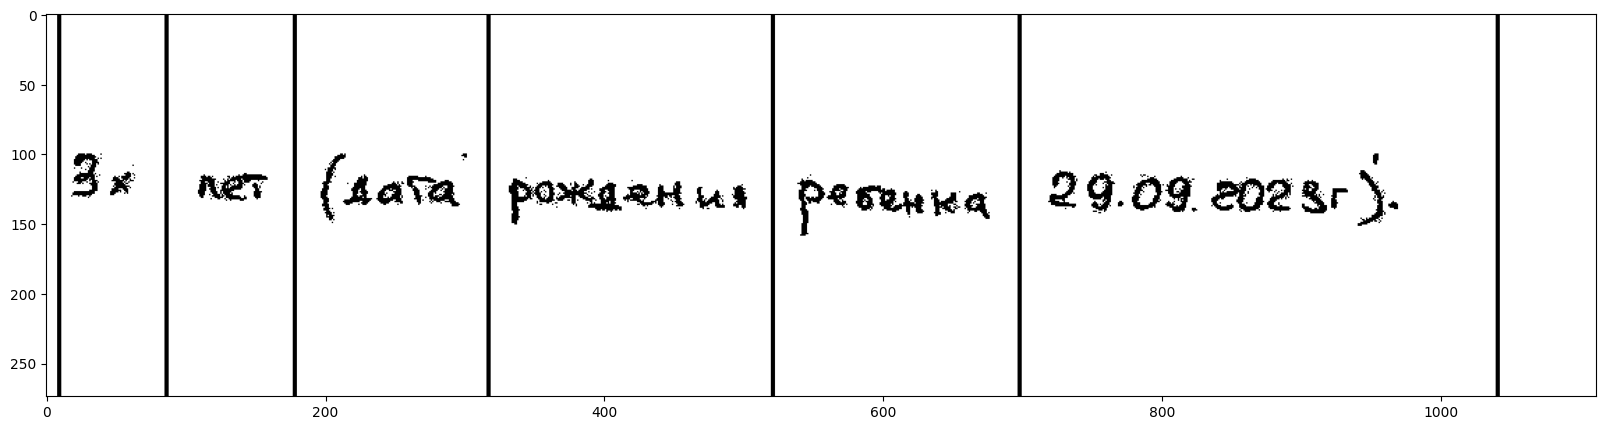

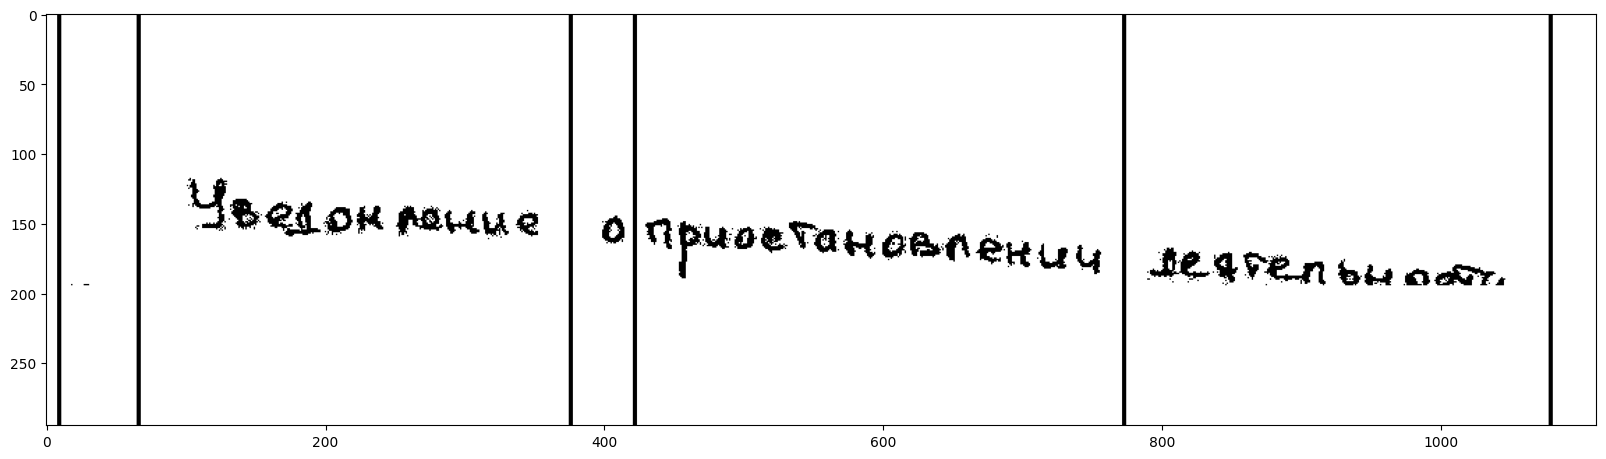

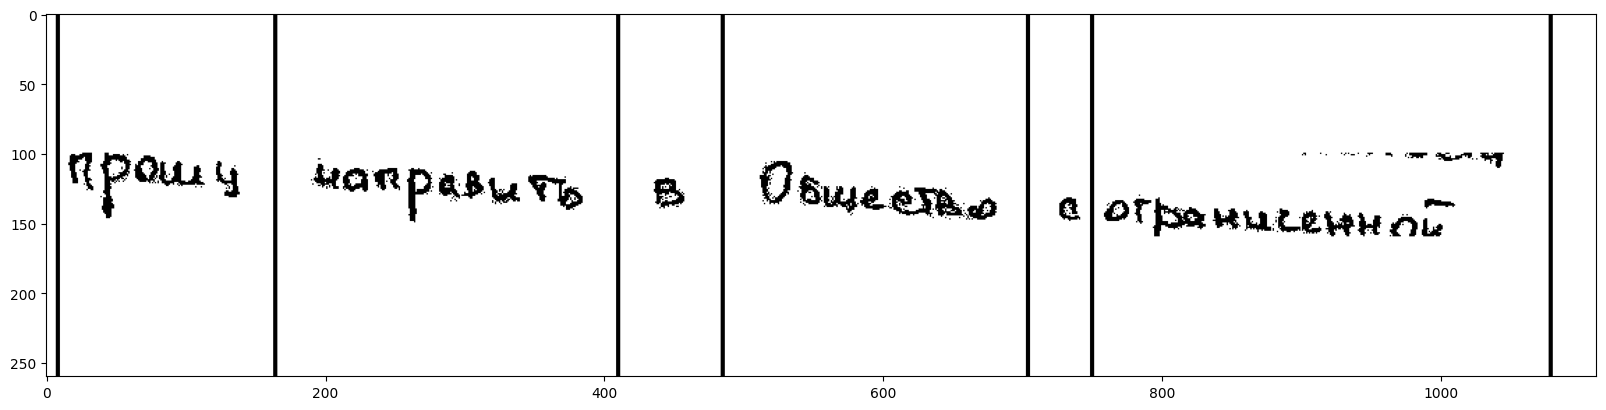

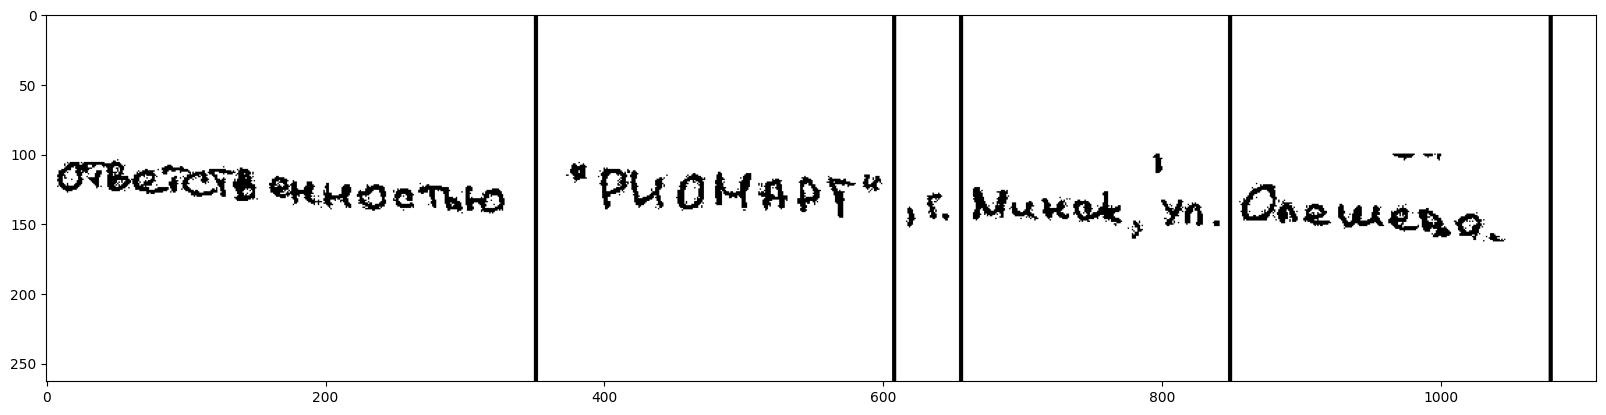

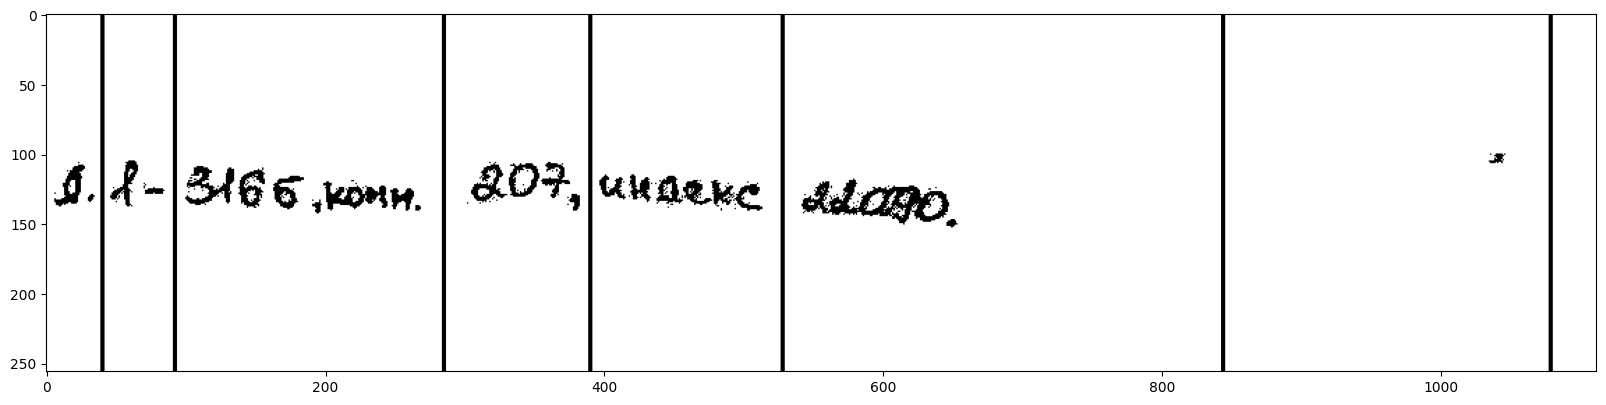

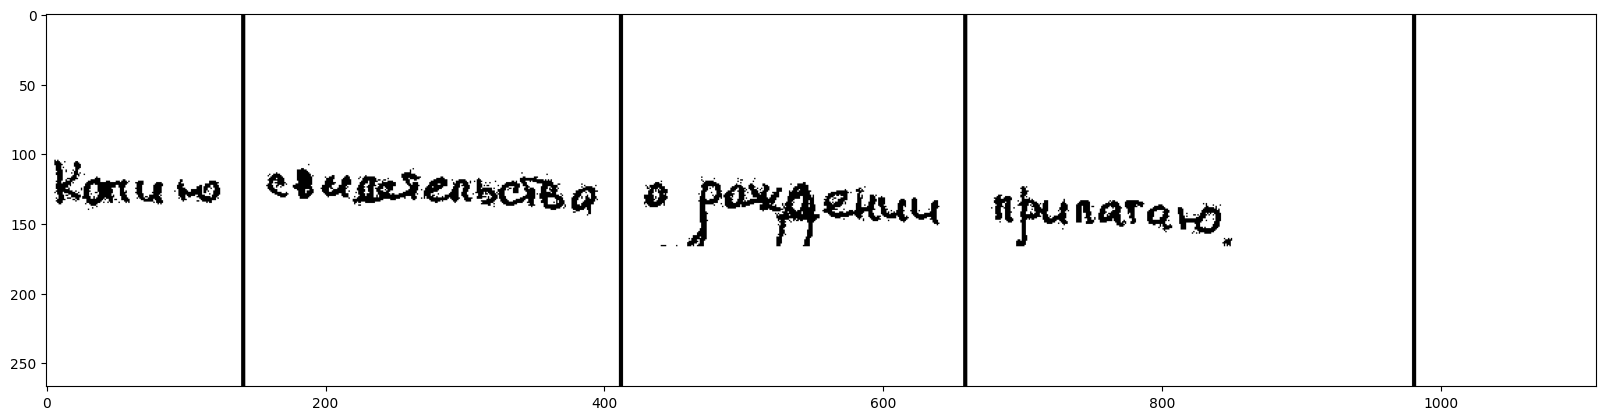

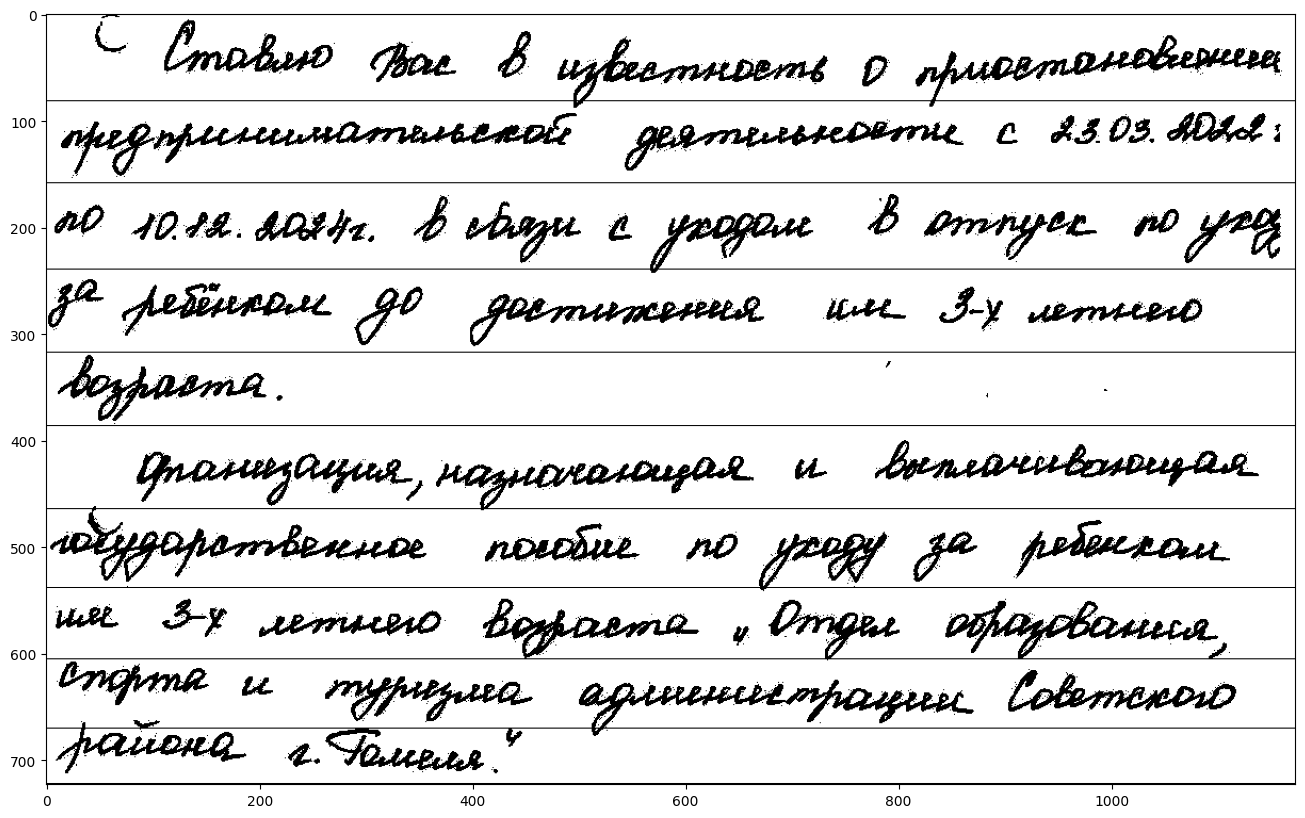

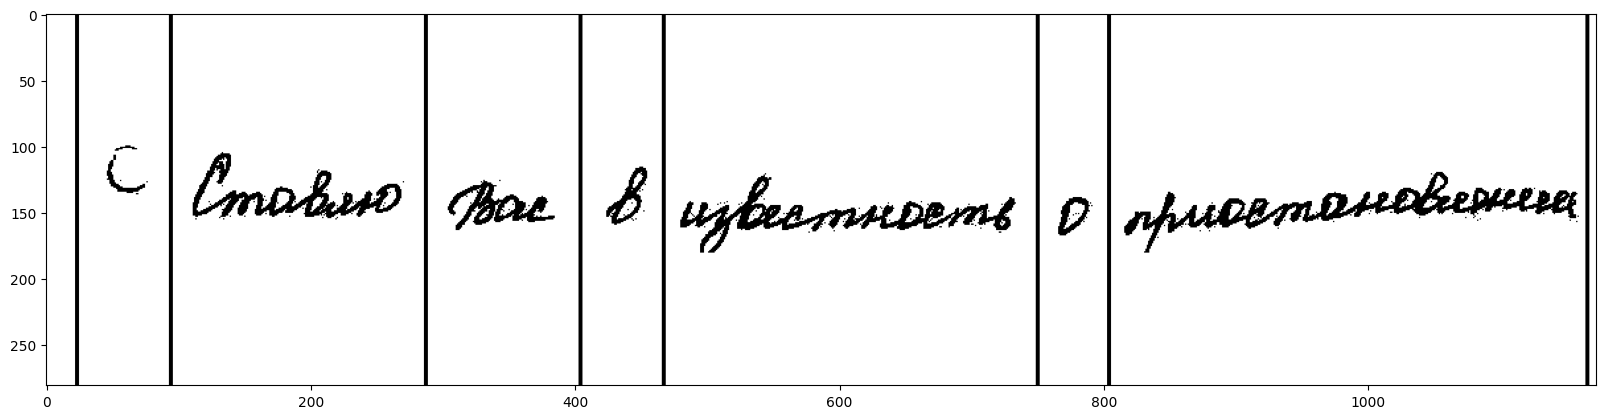

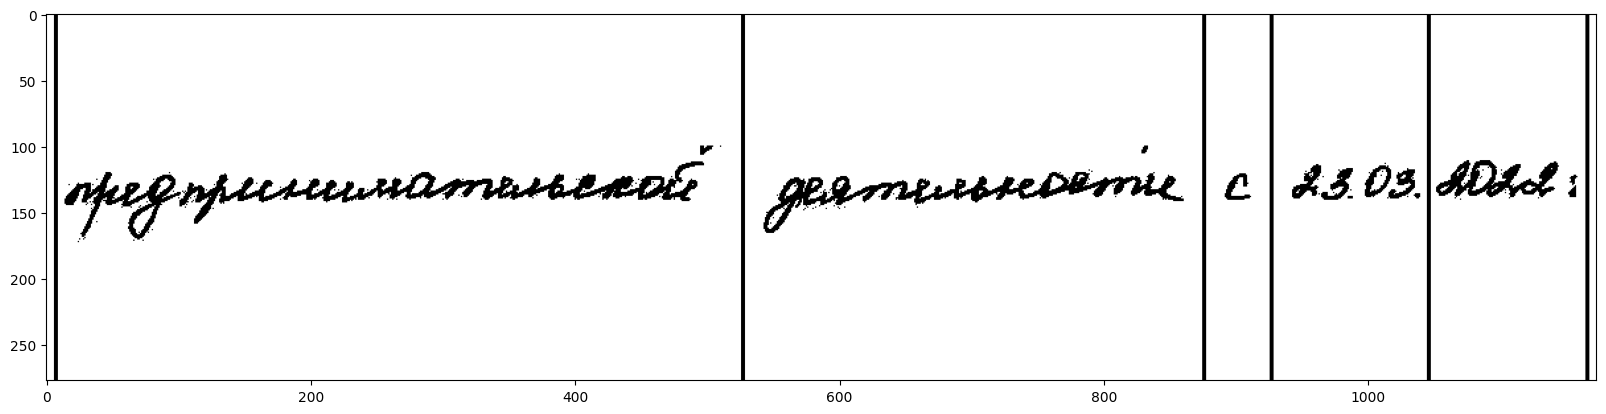

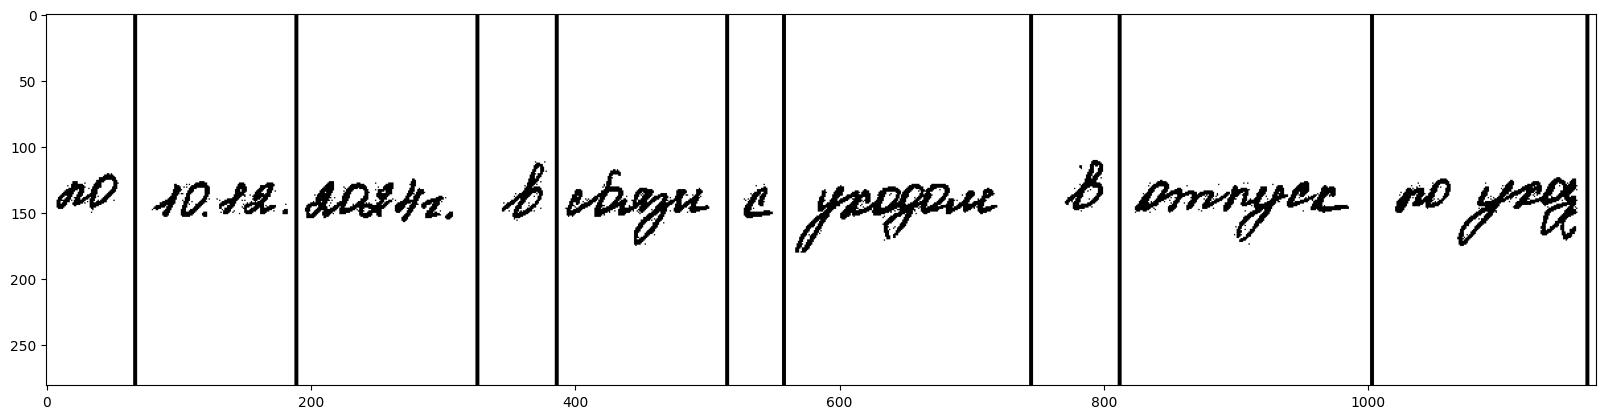

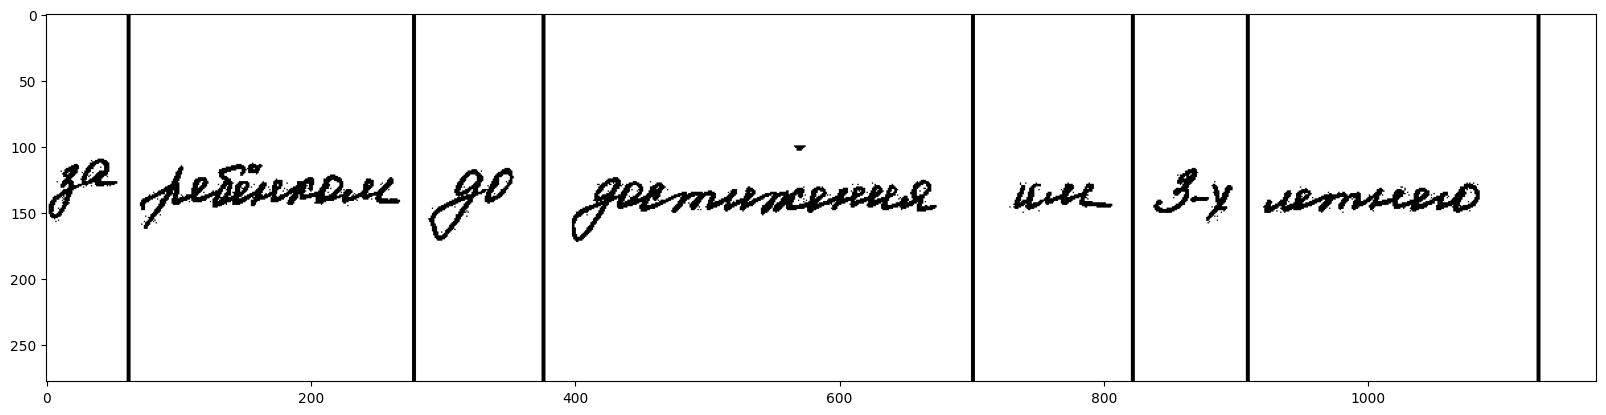

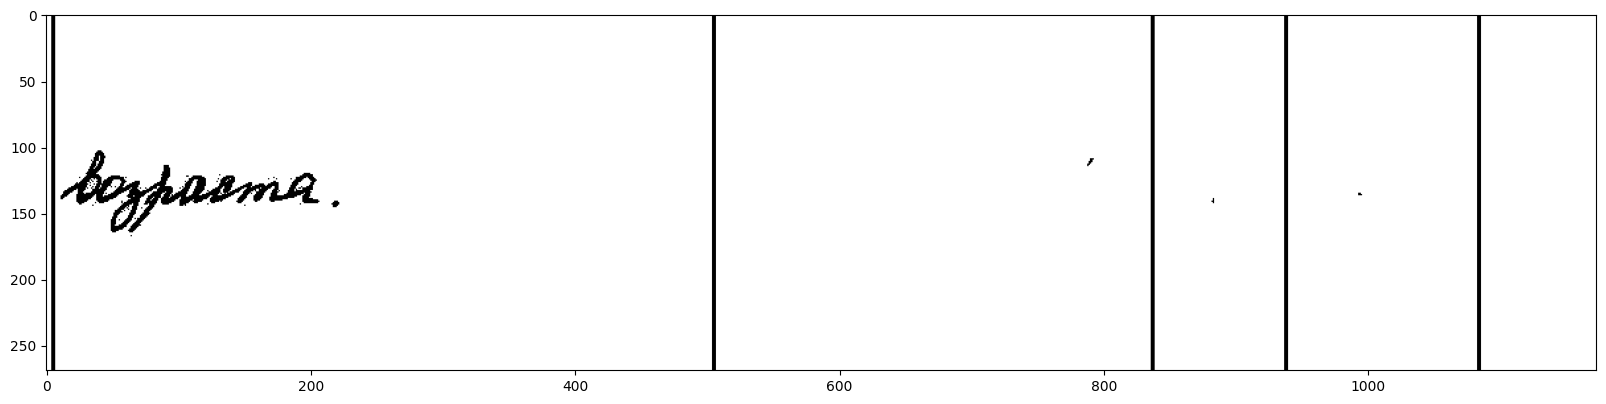

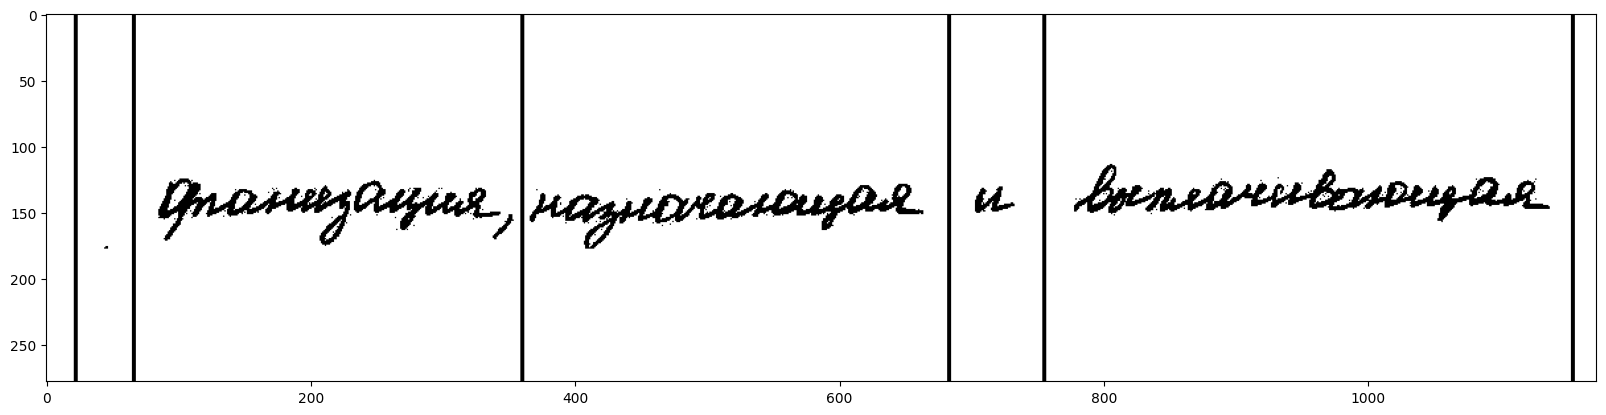

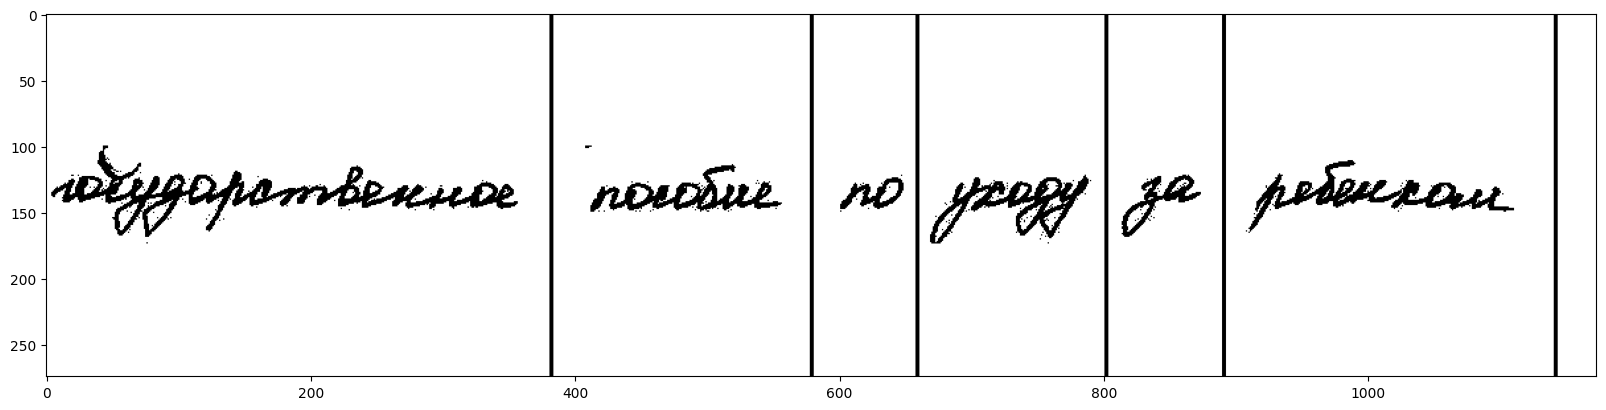

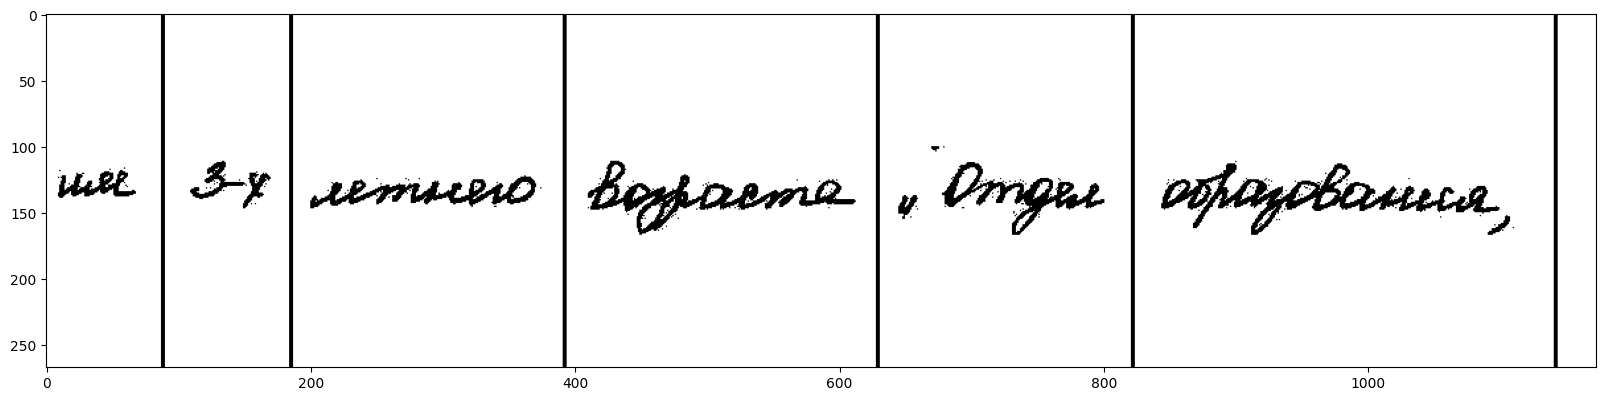

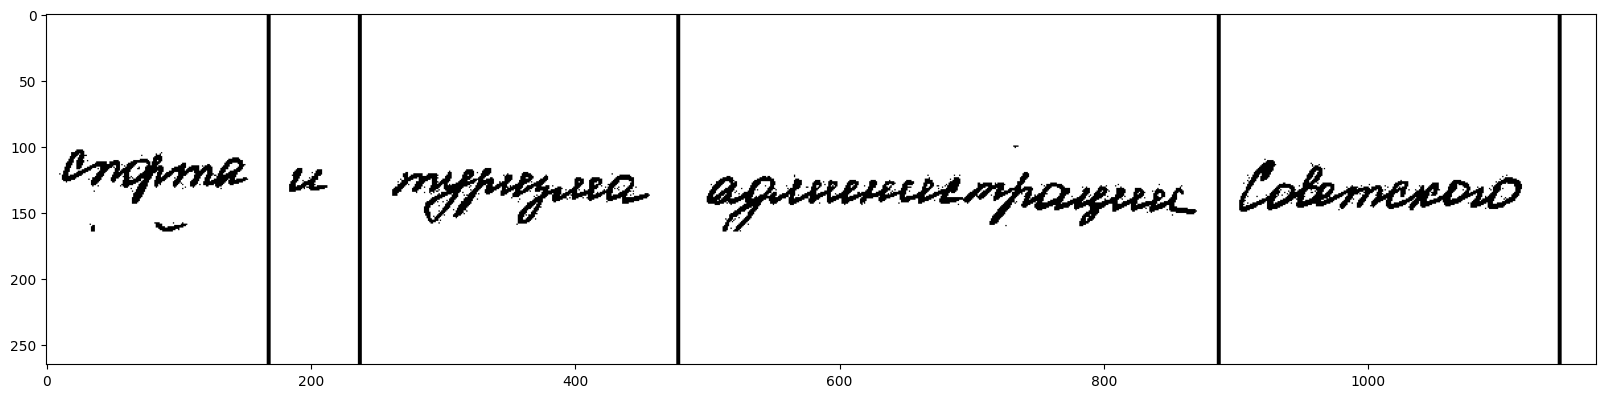

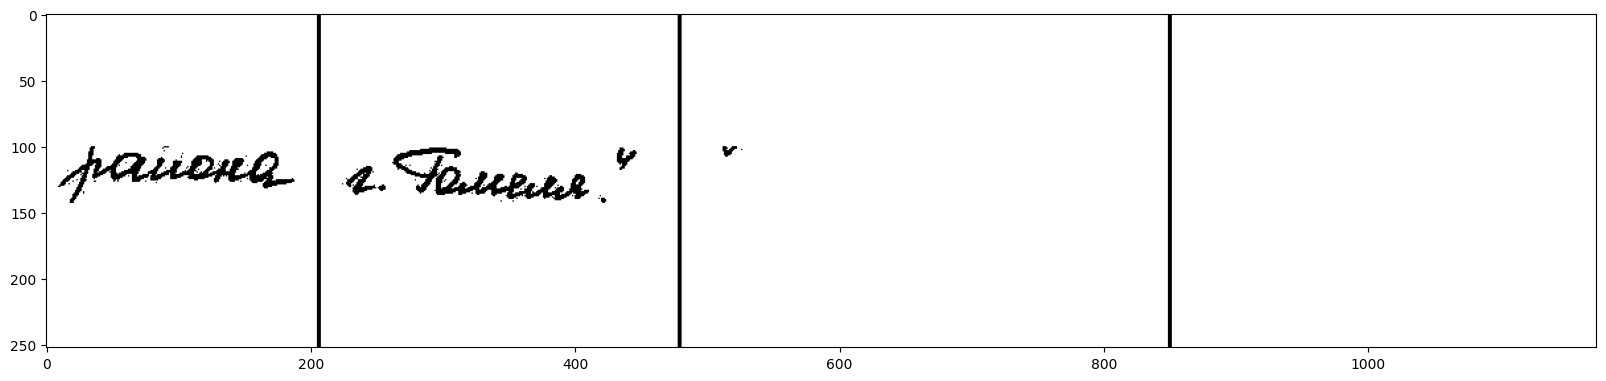

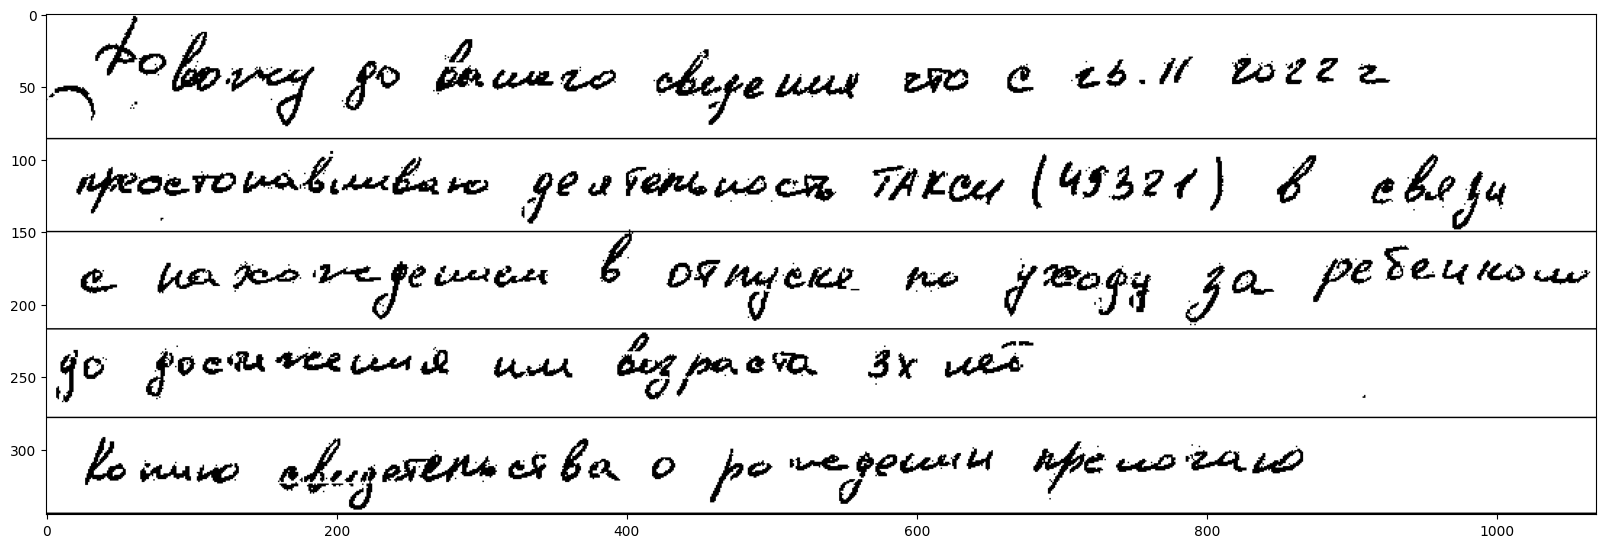

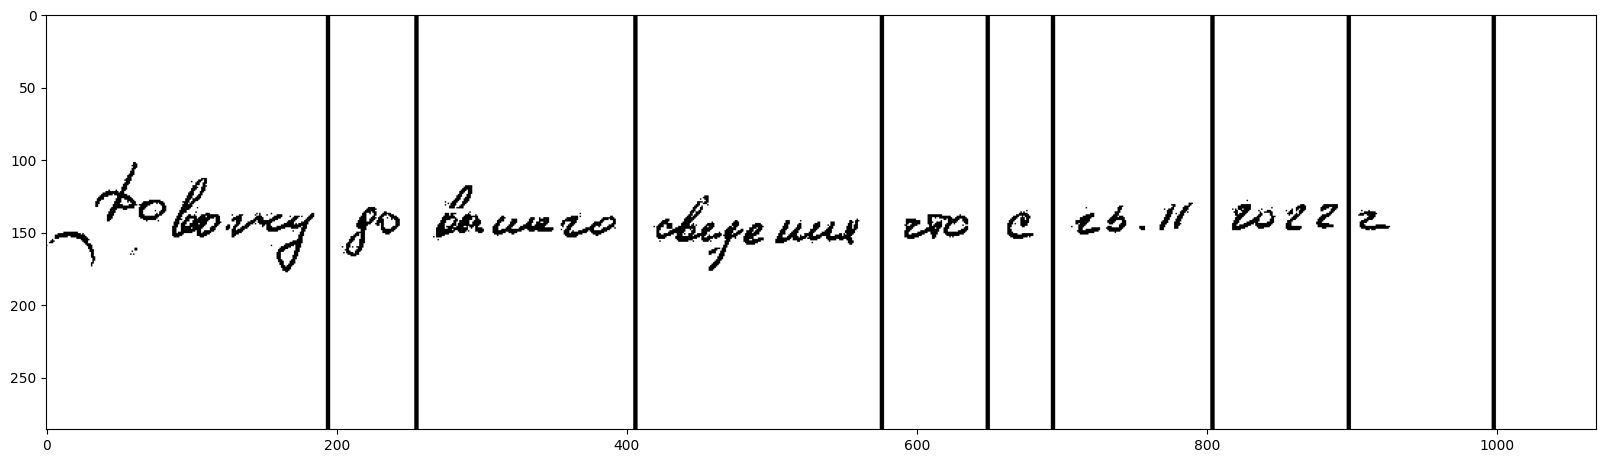

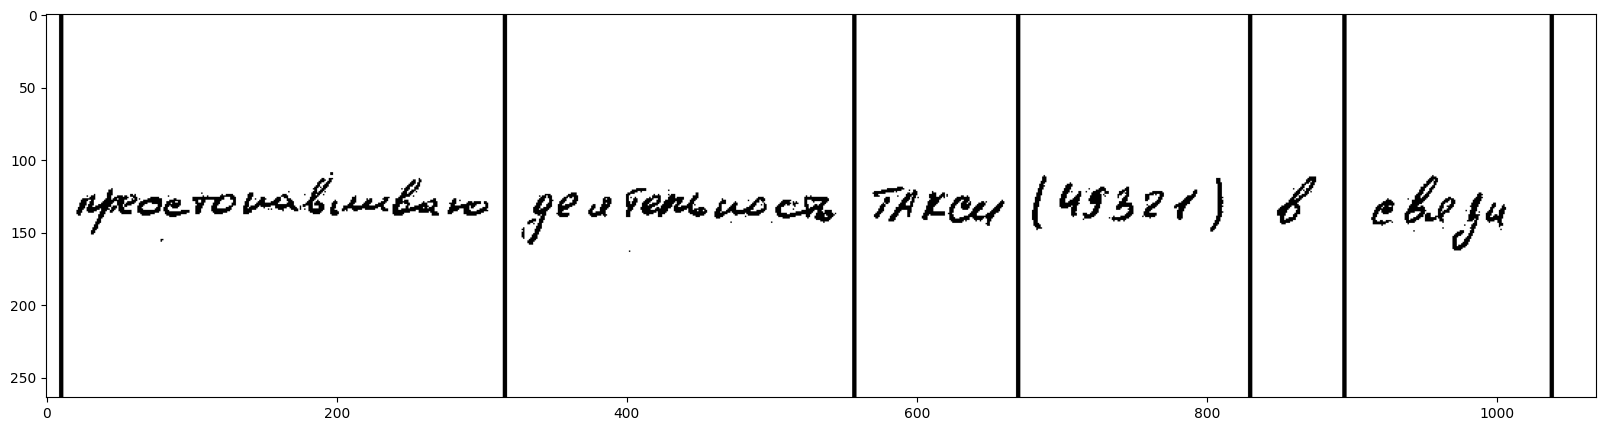

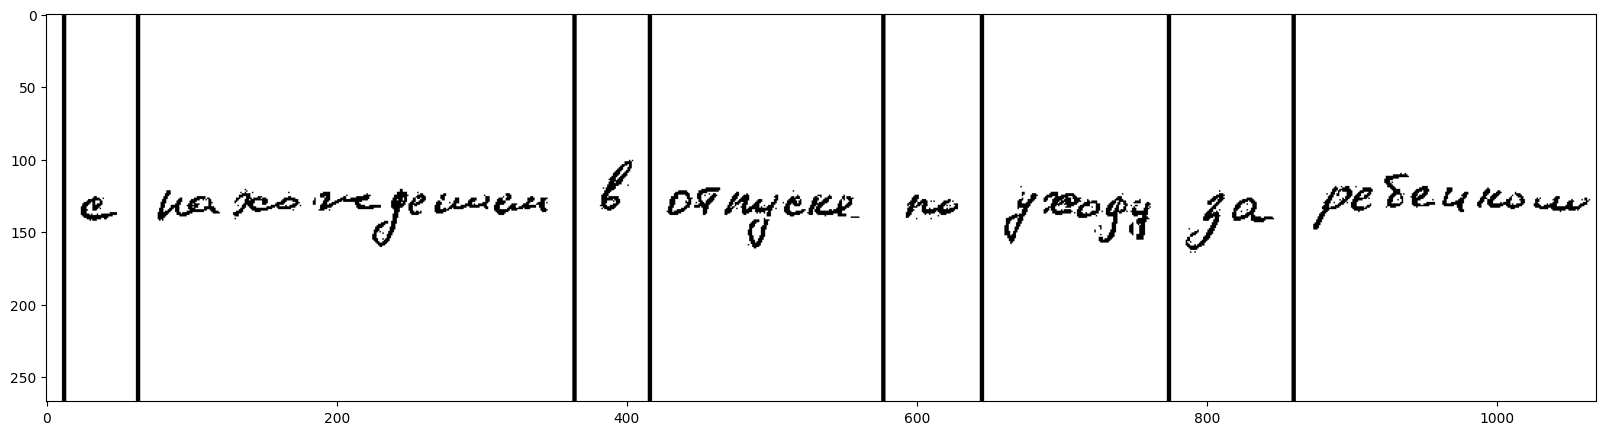

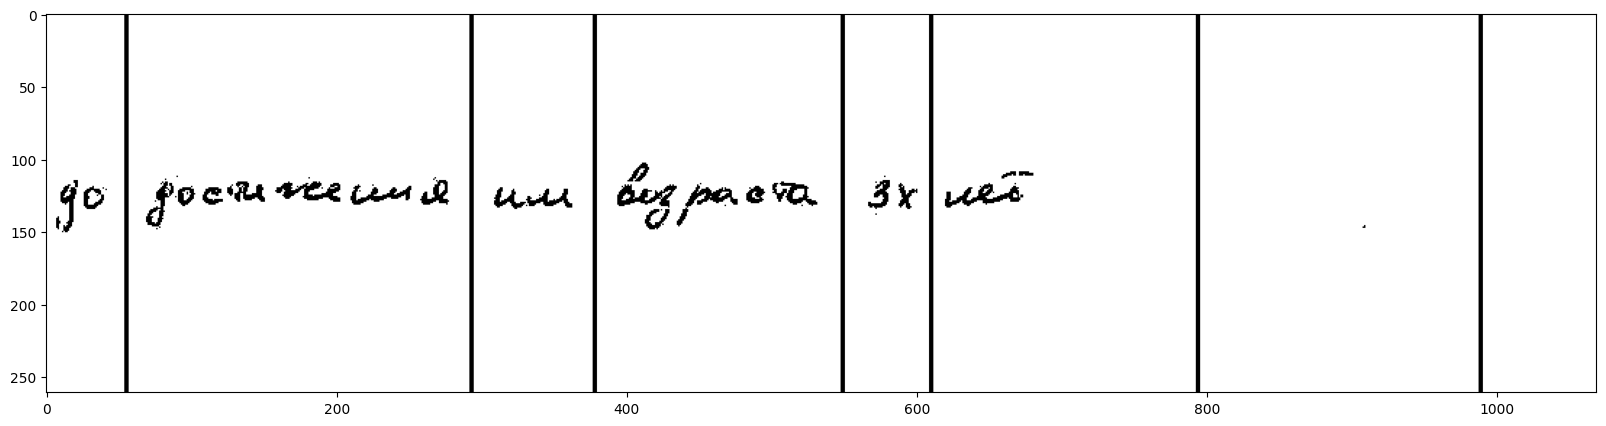

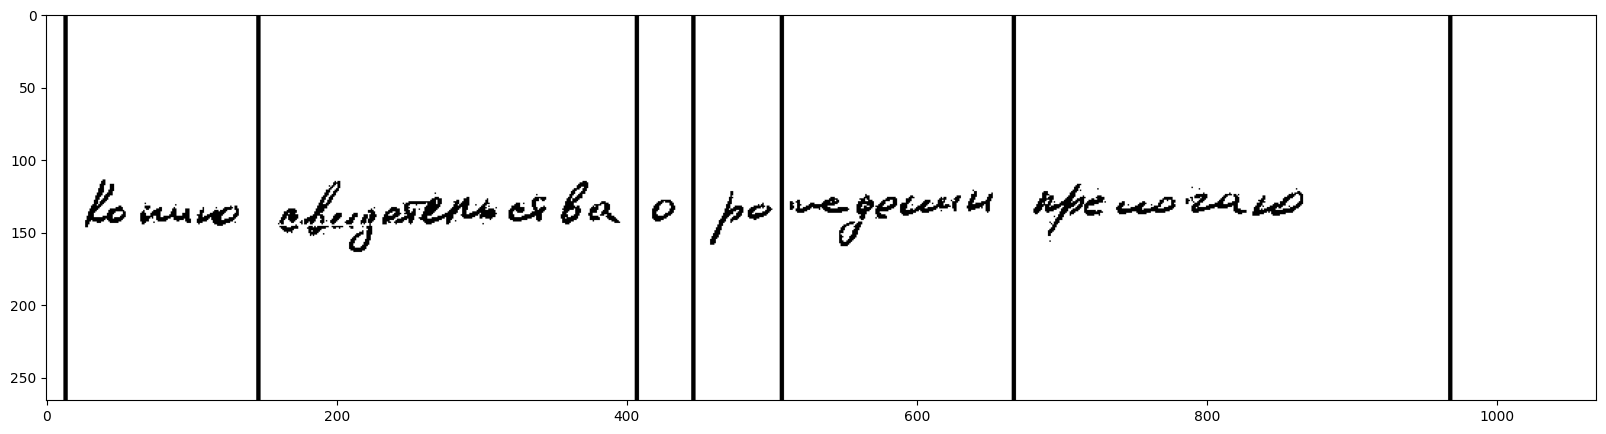

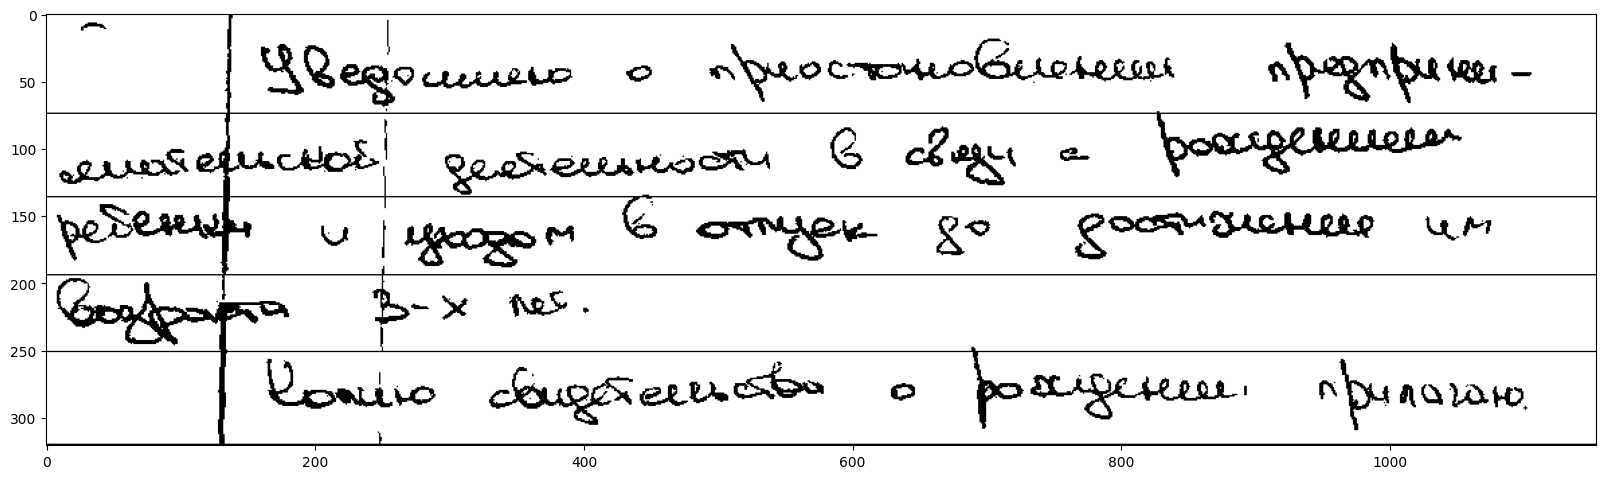

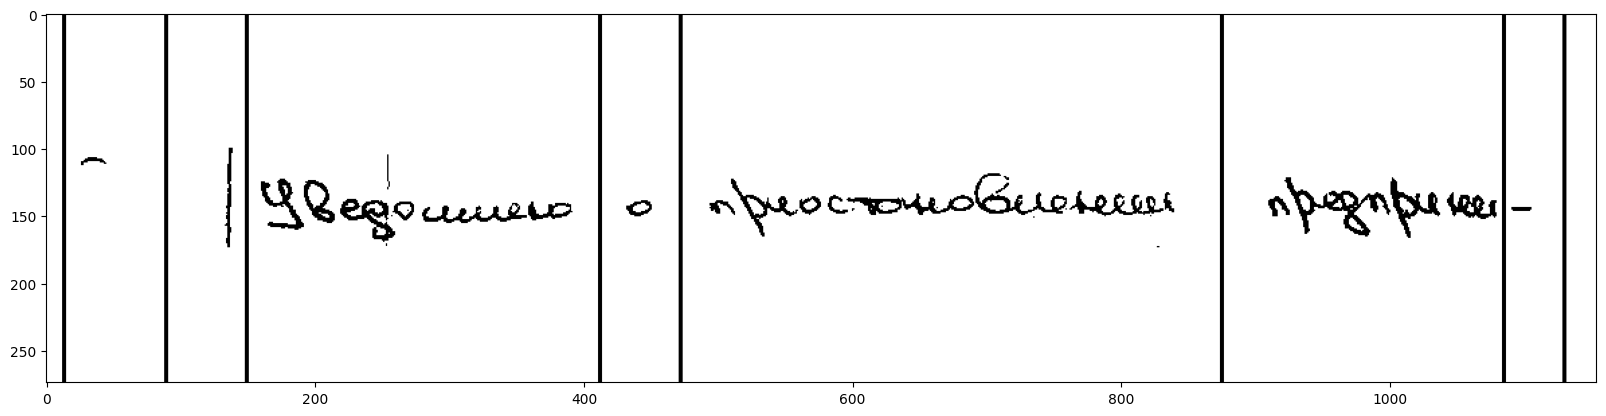

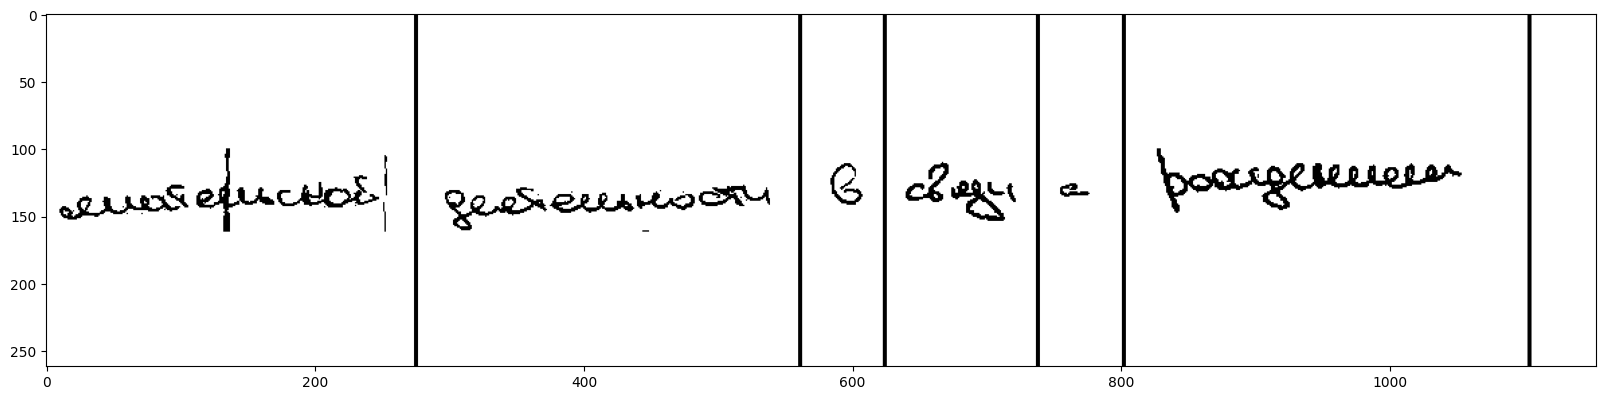

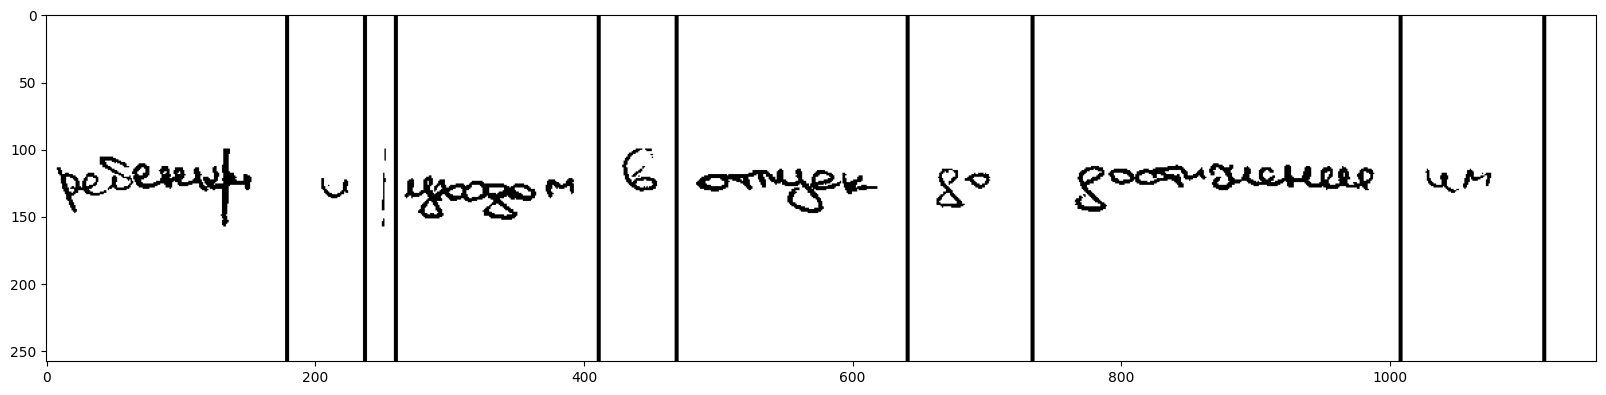

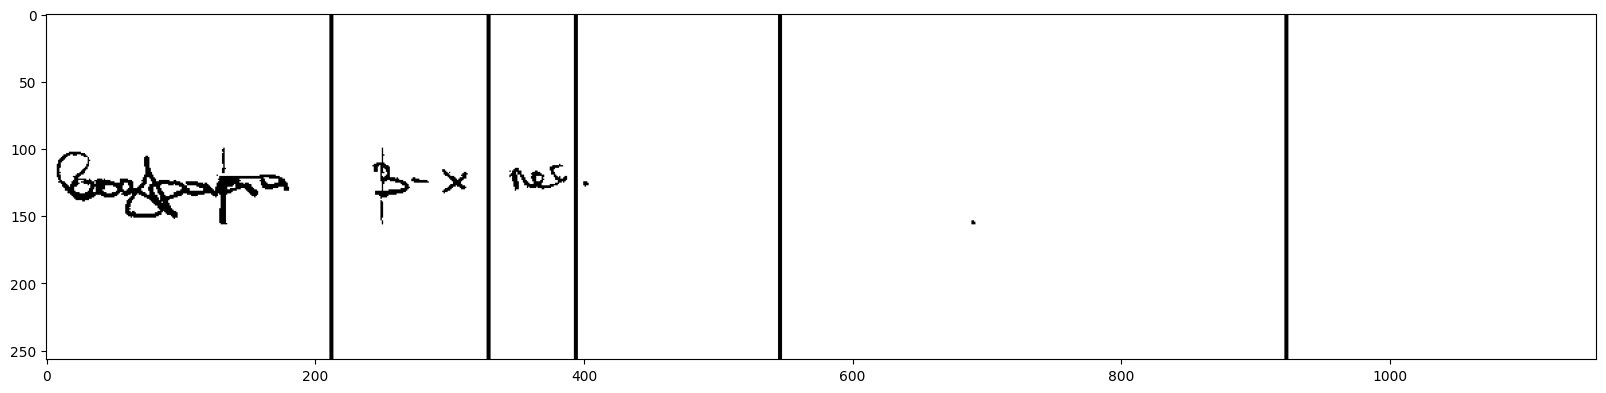

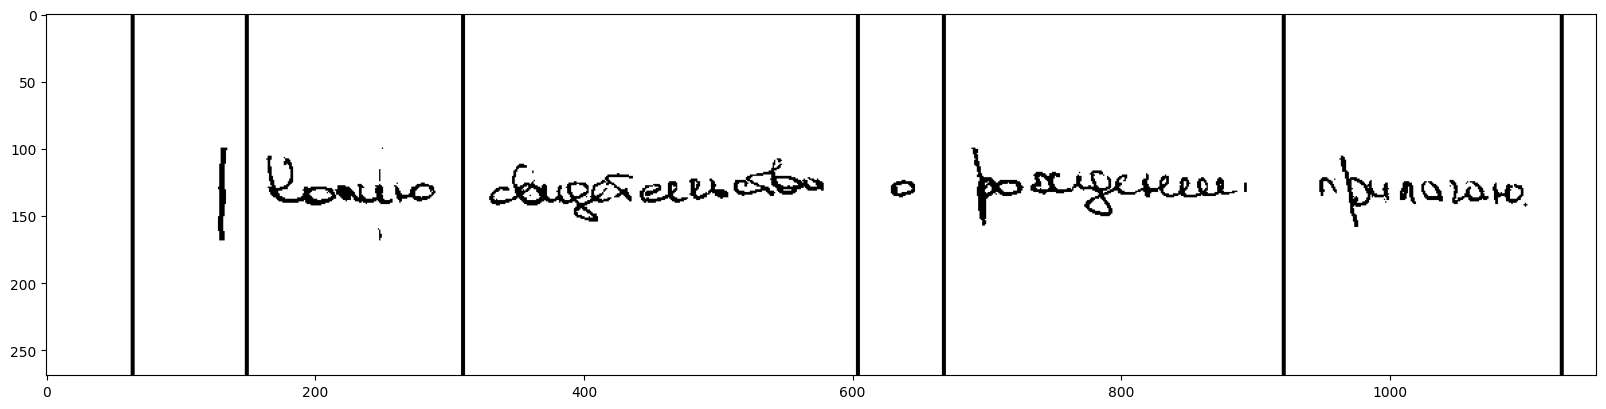

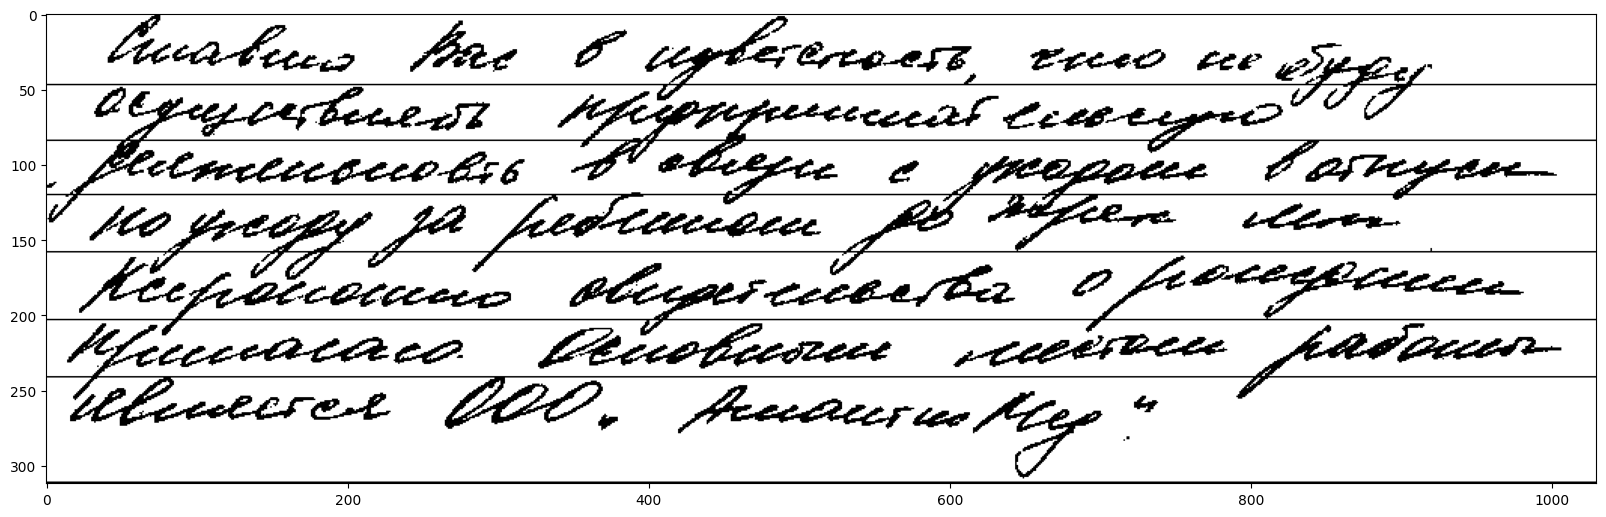

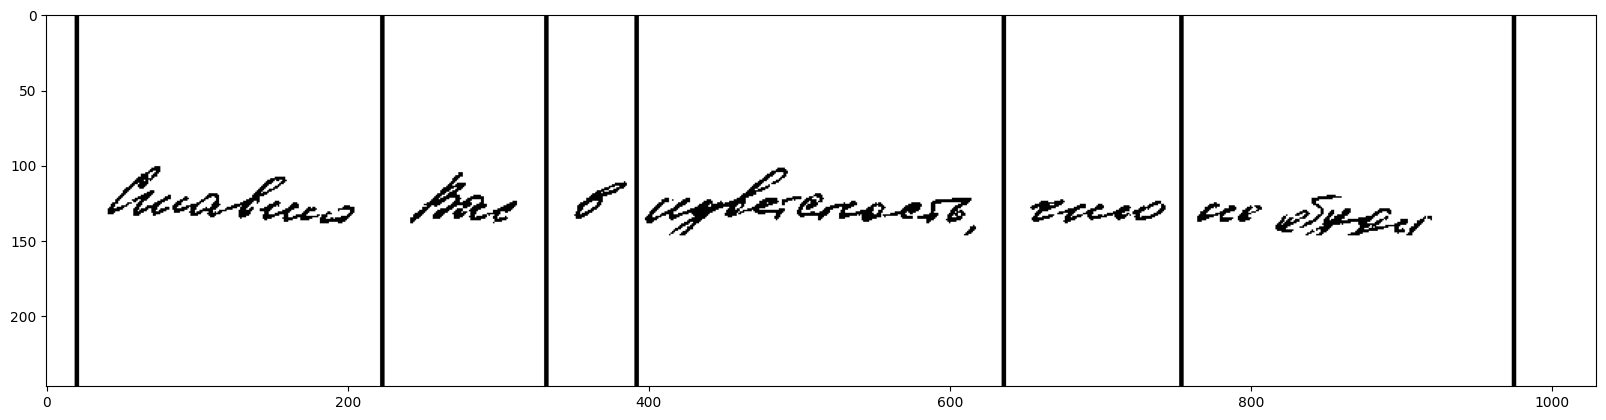

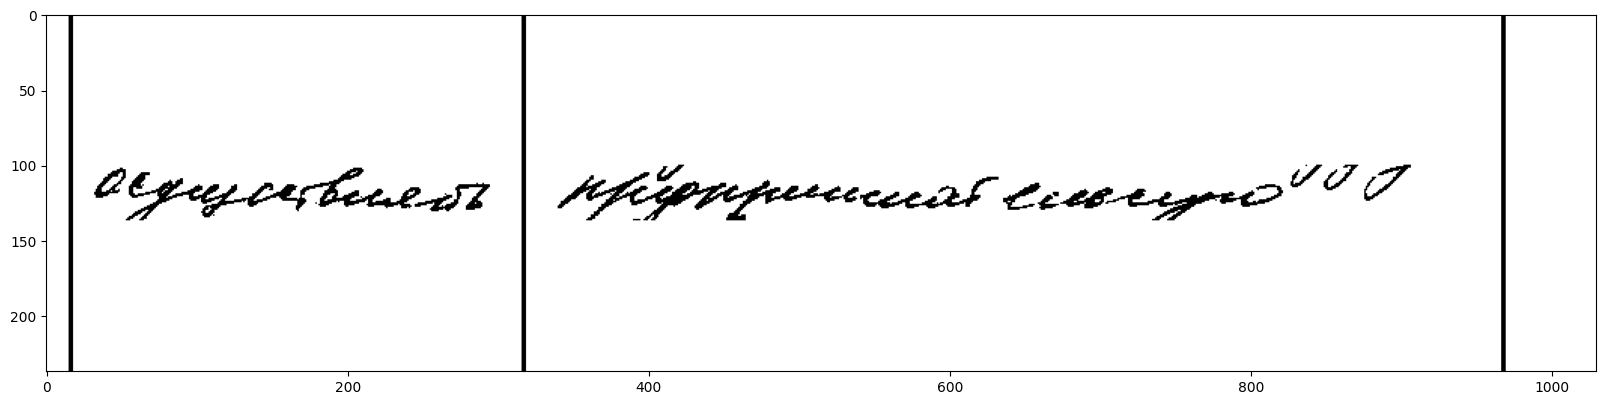

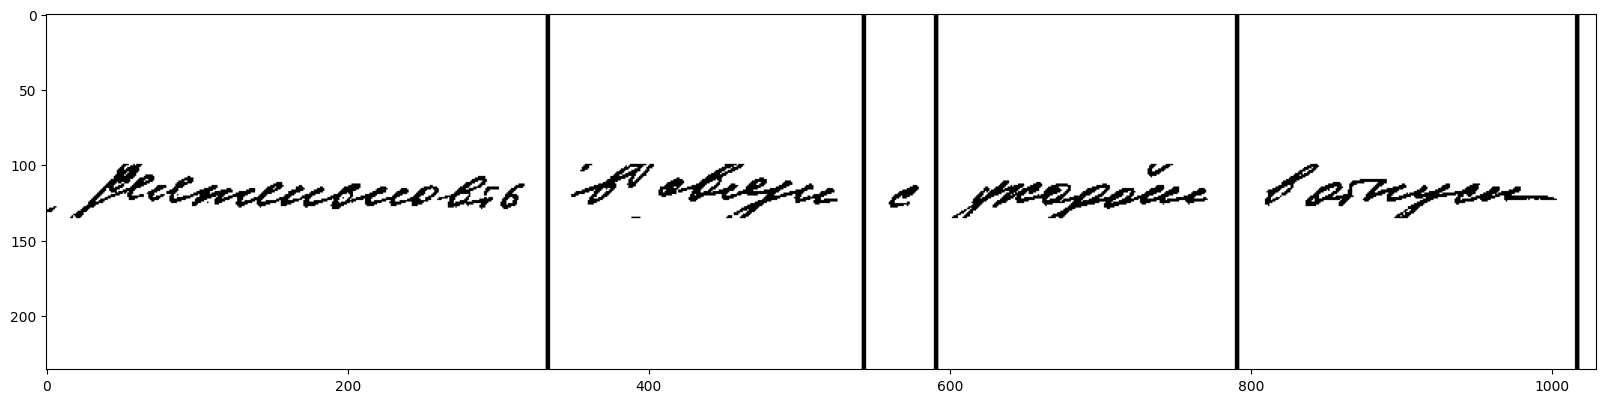

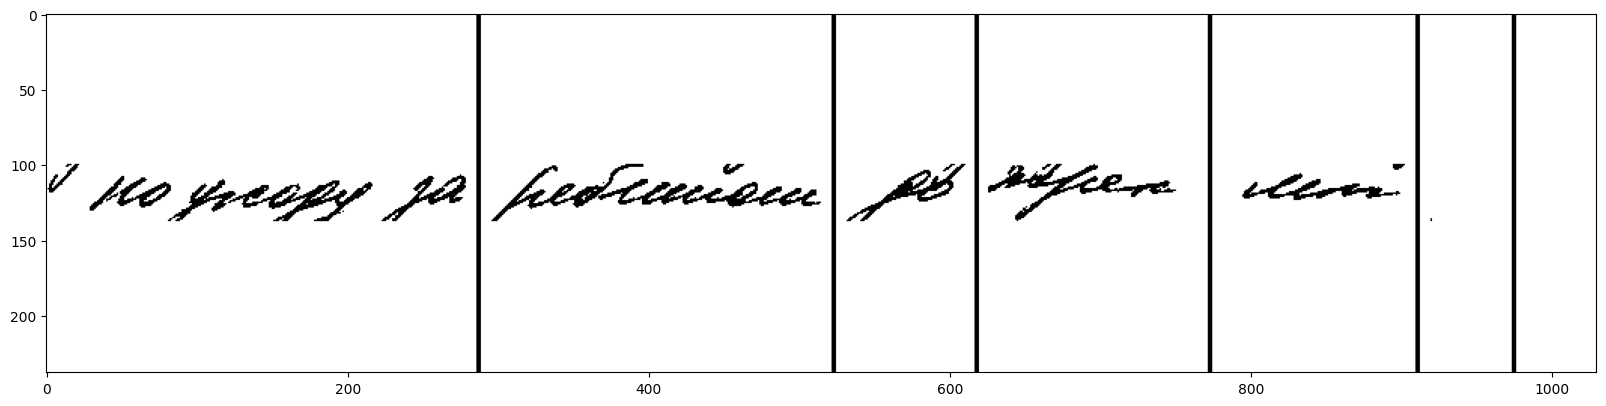

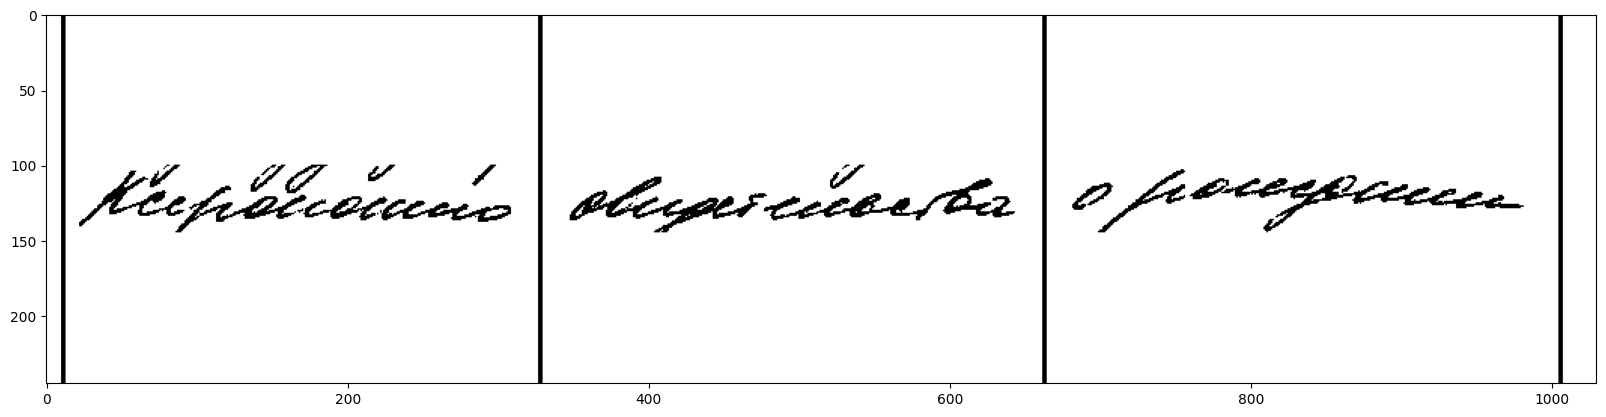

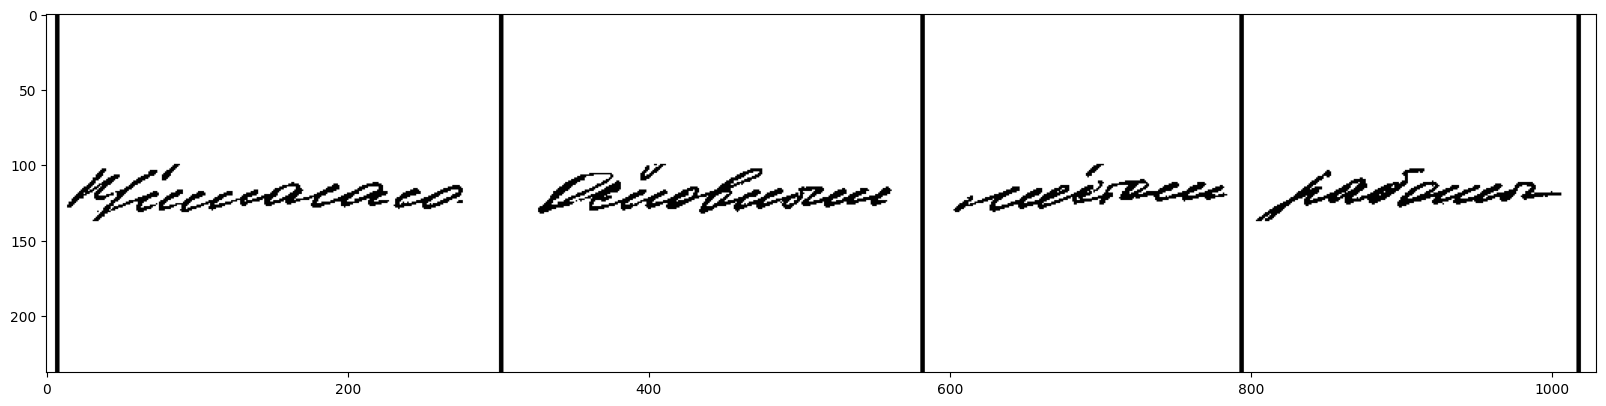

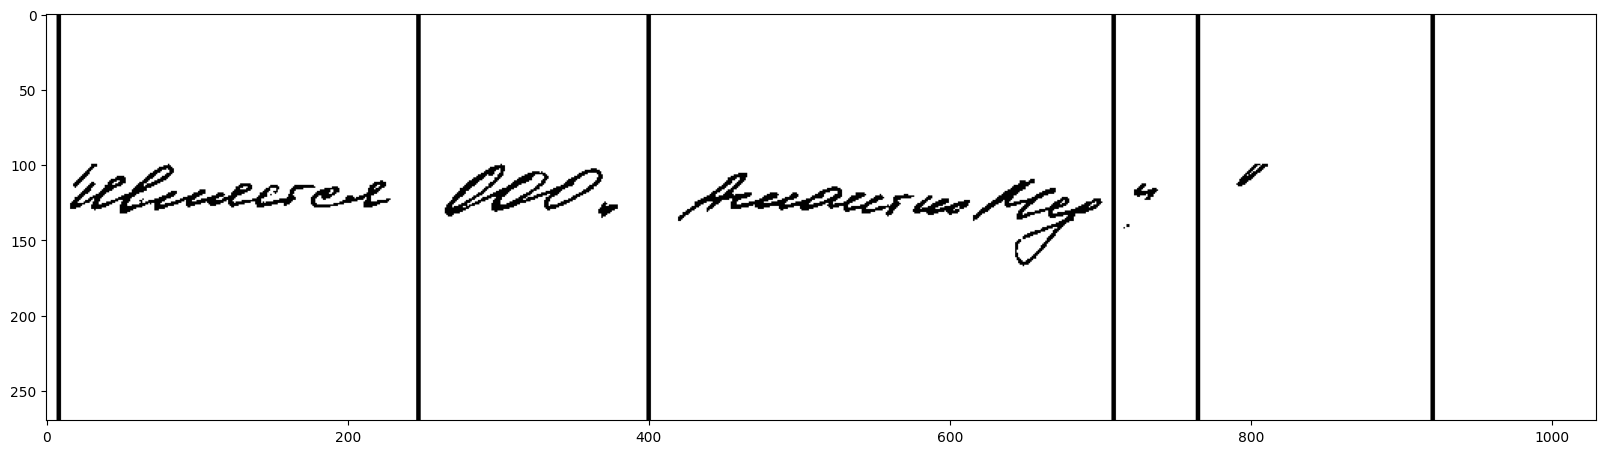

In [21]:
for j in range(1, 10):
    path = f'hand_written_cropped/page_{j}.png'

    img = cv2.imread(path)
    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gaussianFilter = cv2.GaussianBlur(grayImage, (5, 5), 0)
    _, binarizedImage = cv2.threshold(grayImage, 235, 255, cv2.THRESH_BINARY)
    
    binarizedImage[binarizedImage == 0] = 0
    binarizedImage[binarizedImage == 255] = 1
    
    lines = find_dividers(path)
    final = plot_hor_lines(binarizedImage, lines)
    show(final)
    
    for i in range (len(lines) - 1):
        img_line = get_text_line(binarizedImage, lines[i], lines[i + 1], relative_thr=0.3, component_len_thr=5000000)
        
        show(plot_ver_lines(img_line, find_word_dividers(img_line)))ter

In [18]:
def find_word_dividers(img_line, min_len=10):

    vertical_projection = np.sum(img_line, axis=0)
    
    max_val = max(vertical_projection)
    print(max_val)
    
    intervals = []
    
    cur = 0 
    
    while cur < len(vertical_projection):
        if vertical_projection[cur] == max_val:
            start = cur
            end = cur
            while cur < len(vertical_projection) and vertical_projection[cur] == max_val:
                end += 1
                cur += 1
            intervals.append((start, end))
            
        else:
            cur += 1
            
    result = []
    for interval in intervals:
        if (interval[1] - interval[0]) > min_len:
            result.append(int((interval[0] + interval[1]) / 2))
            
    return result
            
    
                
    # print(intervals)
    # plt.plot(vertical_projection)

    # data = []
    # 
    # for i in range(len(vertical_projection)):
    #     data.extend([i] * vertical_projection[i])
    # 
    # kde = gaussian_kde(data,  bw_method=0.03)
    # x_values = np.linspace(np.min(data), np.max(data), 1000)
    # 
    # y_values = kde(x_values)
    # 
    # plt.plot(x_values, y_values)

    # local_maxs = find_local_maximals(y_values, np.max(data))
    # 
    # 
    # return [0] + [item[0] for item in local_maxs[1:-1]] + [img.shape[0] - 1]

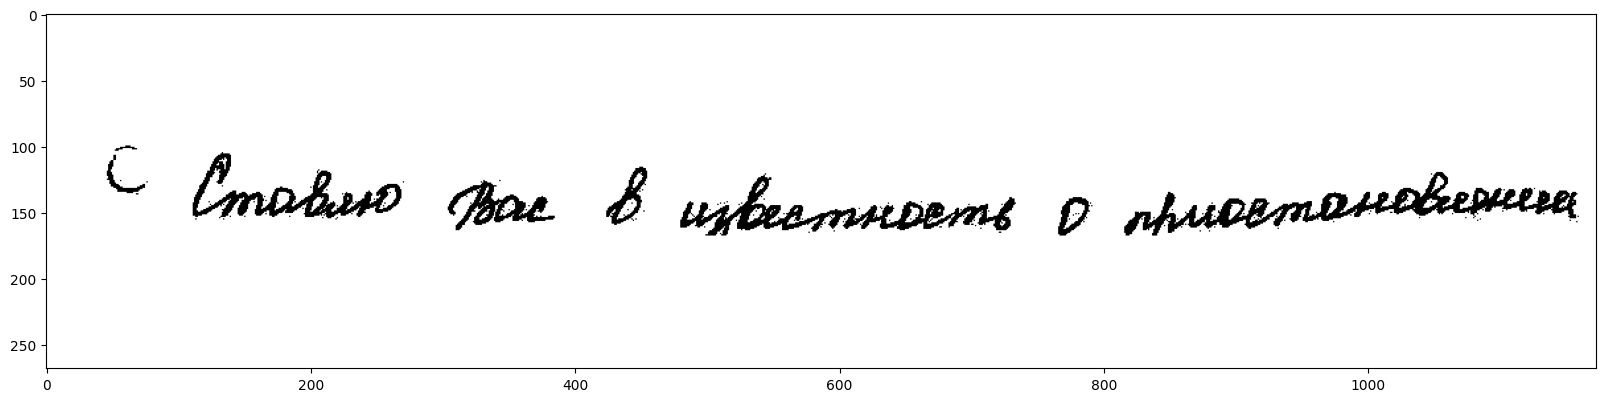

In [10]:
img_line = get_text_line(binarizedImage, lines[0], lines[1], relative_thr=0.3, component_len_thr=5000000)
show(img_line)

268


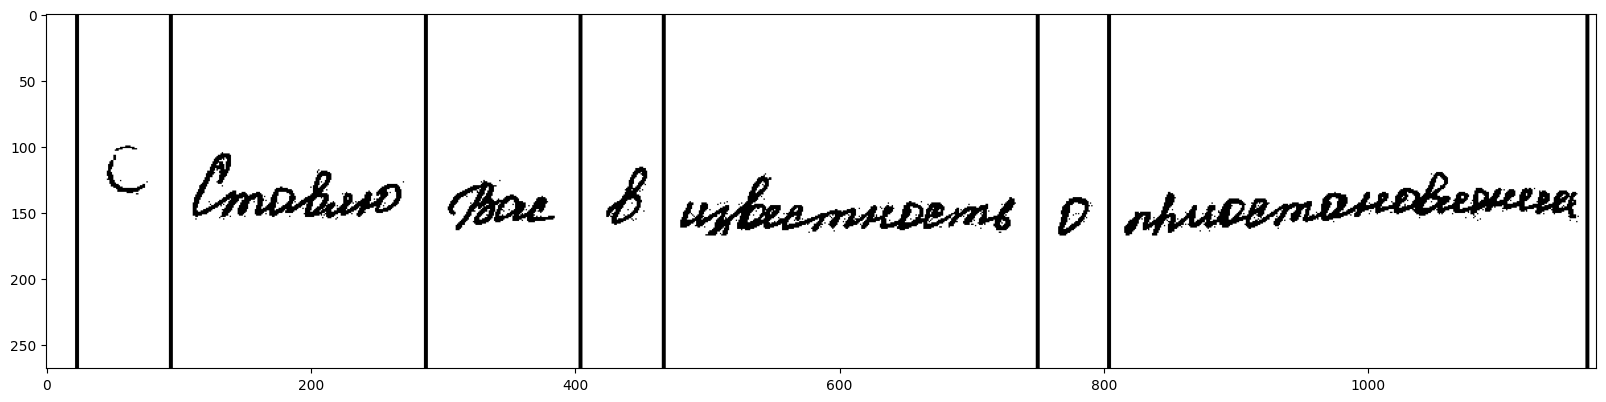

In [20]:
show(plot_ver_lines(img_line, find_word_dividers(img_line)))

In [49]:
vertical_projection = np.sum(img_line, axis=0)
vertical_projection

array([265, 265, 265, ..., 265, 265, 265], dtype=uint64)

width :  1170
height :  388


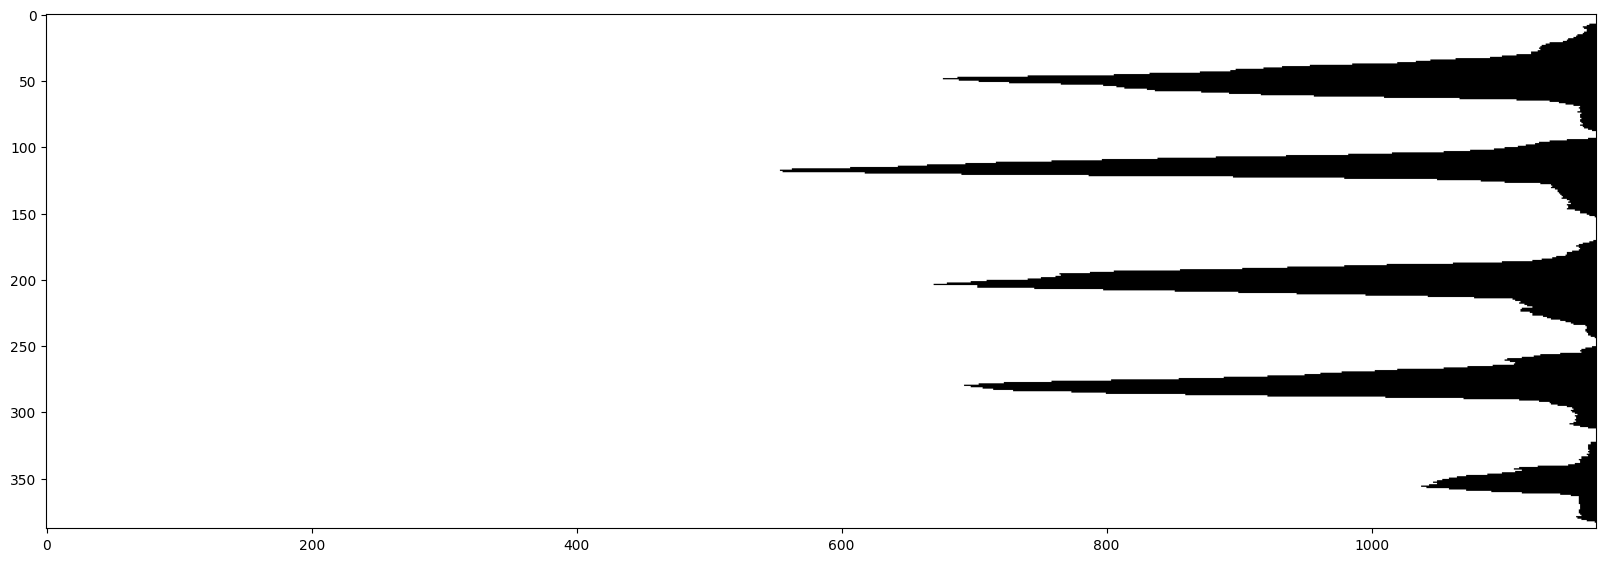

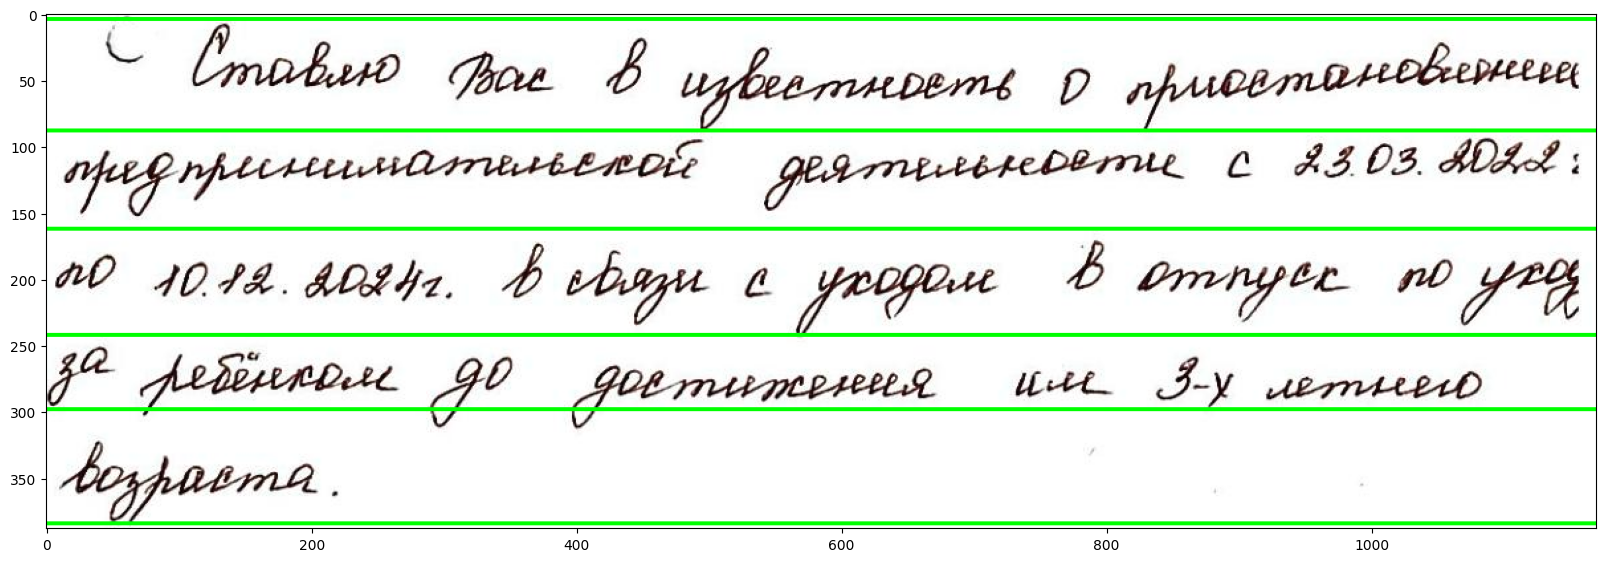

In [111]:
height, width = binarizedImage.shape
print('width : ', width)
print('height : ', height)
blankImage = np.zeros((height, width, 3), np.uint8)

horizontal_projection = np.sum(binarizedImage, axis=1)

for row in range(height):
    # cv2.line(blankImage, (0, row), (int((horizontal_projection[row]) * width / height), row), (255, 255, 255), 1)
    cv2.line(blankImage, (0, row), (int(horizontal_projection[row]), row), (255, 255, 255), 1)
    
show(blankImage)

from scipy.signal import find_peaks, find_peaks_cwt

valleys = find_peaks_cwt(horizontal_projection, np.arange(1, 60))

line_centers = [int(valley) for valley in valleys]

show(plot_hor_lines(img, line_centers))

In [14]:
import seaborn as sns

import matplotlib.pyplot as plt

In [112]:
data = []

for i in range(len(horizontal_projection)):
    data.extend([i] * horizontal_projection[i])

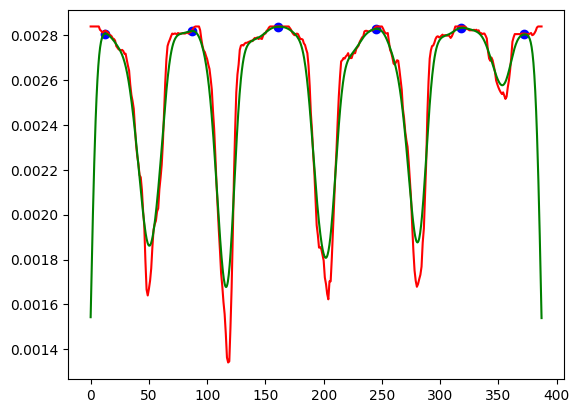

In [126]:

kde = gaussian_kde(data,  bw_method=0.04)
x_values = np.linspace(np.min(data), np.max(data), 1000)

y_values = kde(x_values)

local_maxs = find_local_maximals(y_values)

# plt.plot(horizontal_projection)
plt.plot(horizontal_projection / np.sum(horizontal_projection), color='r')
plt.plot(x_values, y_values, color='g')
plt.scatter([item[0] for item in local_maxs], [item[1] for item in local_maxs], color='b')

In [118]:
y_values

array([0.00154326, 0.00163896, 0.00173304, 0.00182483, 0.00191373,
       0.0019992 , 0.00208076, 0.00215801, 0.00223064, 0.0022984 ,
       0.00236115, 0.00241883, 0.00247143, 0.00251905, 0.00256181,
       0.00259991, 0.0026336 , 0.00266313, 0.00268881, 0.00271096,
       0.00272987, 0.00274589, 0.00275931, 0.00277044, 0.00277955,
       0.00278691, 0.00279276, 0.00279732, 0.00280078, 0.0028033 ,
       0.00280505, 0.00280614, 0.00280669, 0.00280679, 0.0028065 ,
       0.0028059 , 0.00280503, 0.00280394, 0.00280265, 0.0028012 ,
       0.0027996 , 0.00279787, 0.00279601, 0.00279405, 0.002792  ,
       0.00278984, 0.0027876 , 0.00278529, 0.00278289, 0.00278043,
       0.0027779 , 0.00277532, 0.00277267, 0.00276997, 0.00276722,
       0.00276442, 0.00276156, 0.00275865, 0.00275568, 0.00275265,
       0.00274953, 0.00274633, 0.00274303, 0.00273962, 0.00273606,
       0.00273235, 0.00272846, 0.00272435, 0.00272001, 0.00271541,
       0.00271051, 0.00270528, 0.0026997 , 0.00269373, 0.00268

[(12.771, 0.0028067850709764287),
 (87.075, 0.00281824469825899),
 (161.766, 0.0028374134692398917),
 (245.358, 0.0028282324588100784),
 (318.888, 0.002832638974042853),
 (372.294, 0.0028032500900900094)]

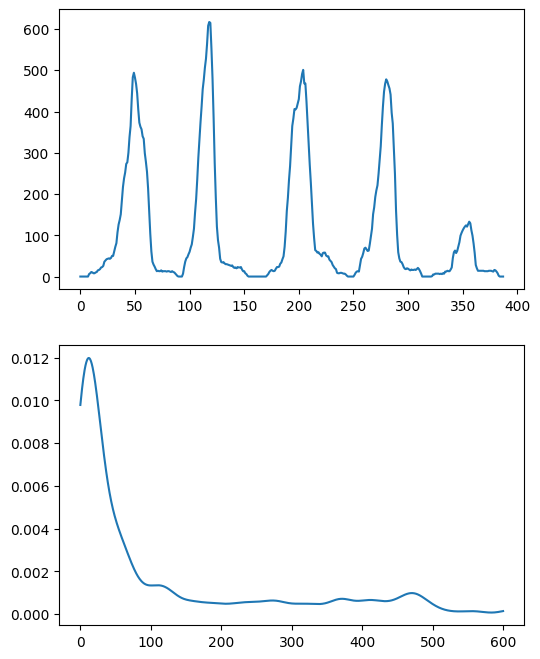

In [44]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(horizontal_projection,  bw_method=0.1)
x_values = np.linspace(0, 600, 1000)

y_values = kde(x_values)

fig, ax = plt.subplots(2, 1, figsize=(6, 8))

ax[0].plot(horizontal_projection)
ax[1].plot(x_values, y_values)

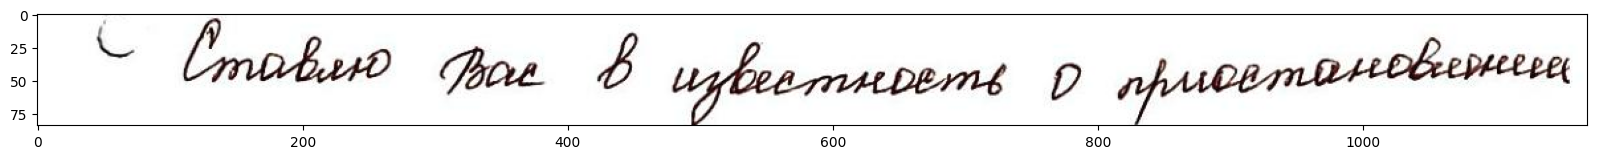

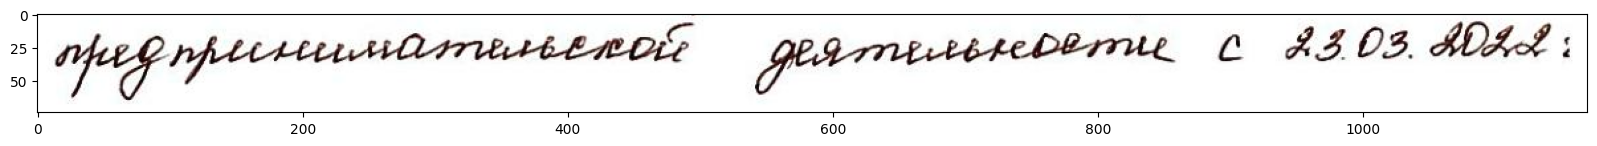

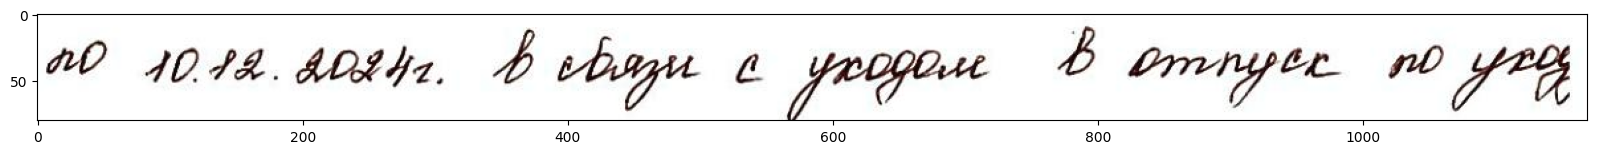

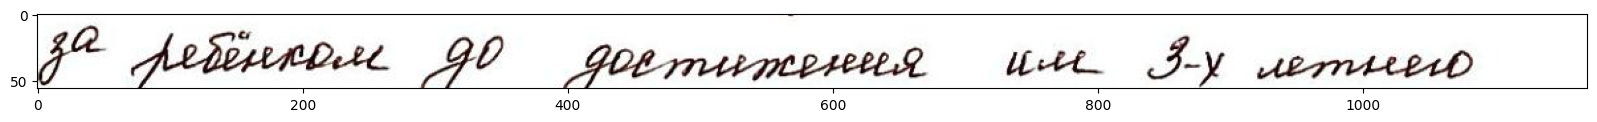

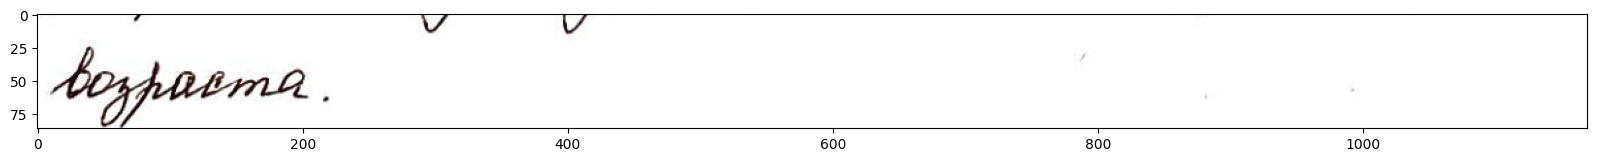

In [47]:
lines = []
for i in range(1, len(line_centers)):
    lines.append(img[line_centers[i - 1]: line_centers[i], 0: img.shape[1]])
    show(lines[-1])

In [48]:
line = lines[0]



In [71]:
def find_plateaus(seq, cmpwith):
    result = []
    start = None
    end = None
    
    for i, value in enumerate(seq):
        if value == cmpwith and start is None:
            end = None
            start = i
        if value != cmpwith and end is None:
            end = i
            result.append((start, end))
            start = None
    
    if start is not None and end is None:
        result.append((start, i))
            
    return result

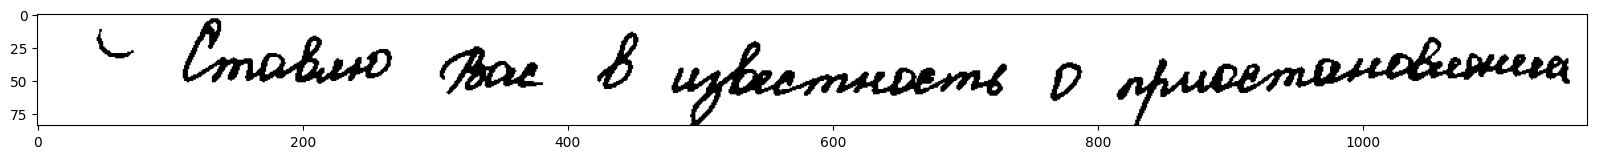

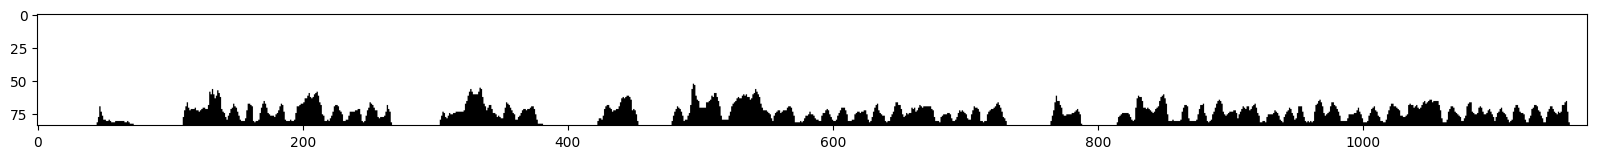

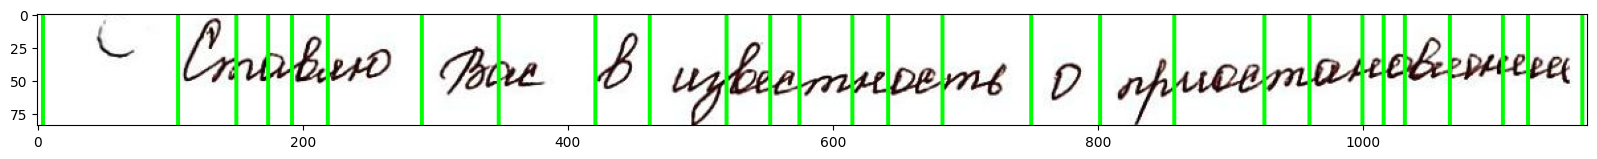

In [61]:
grayImage = cv2.cvtColor(line, cv2.COLOR_BGR2GRAY)

gaussianFilter = cv2.GaussianBlur(grayImage, (5, 5), 0)


_, binarizedImage = cv2.threshold(gaussianFilter, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

show(binarizedImage)

binarizedImage[binarizedImage == 0] = 0
binarizedImage[binarizedImage == 255] = 1


height, width = binarizedImage.shape


blankImage = np.zeros((height, width, 3), np.uint8)

vertical_projection = np.sum(binarizedImage, axis=0)

for column in range(width):
    # cv2.line(blankImage, (0, row), (int((horizontal_projection[row]) * width / height), row), (255, 255, 255), 1)
    cv2.line(blankImage, (column, 0), (column, int(vertical_projection[column])), (255, 255, 255), 1)
    
show(blankImage)

valleys = find_peaks_cwt(vertical_projection, np.arange(1, 30))

line_centers = [int(valley) for valley in valleys]

show(plot_ver_lines(line, line_centers))

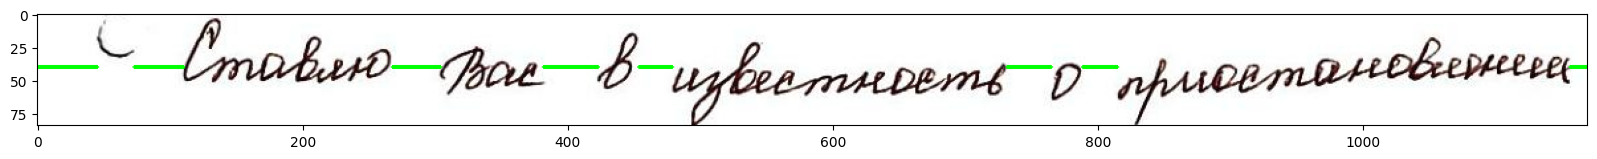

In [77]:
plateaus = find_plateaus(vertical_projection, 84)
line_copy = line.copy()
for item in plateaus:
    cv2.line(line_copy, (item[0], 40), (item[1], 40), (0, 255, 0) , 2)
    
show(line_copy)

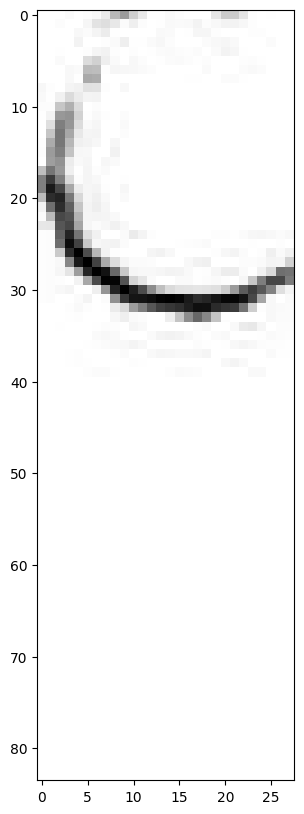

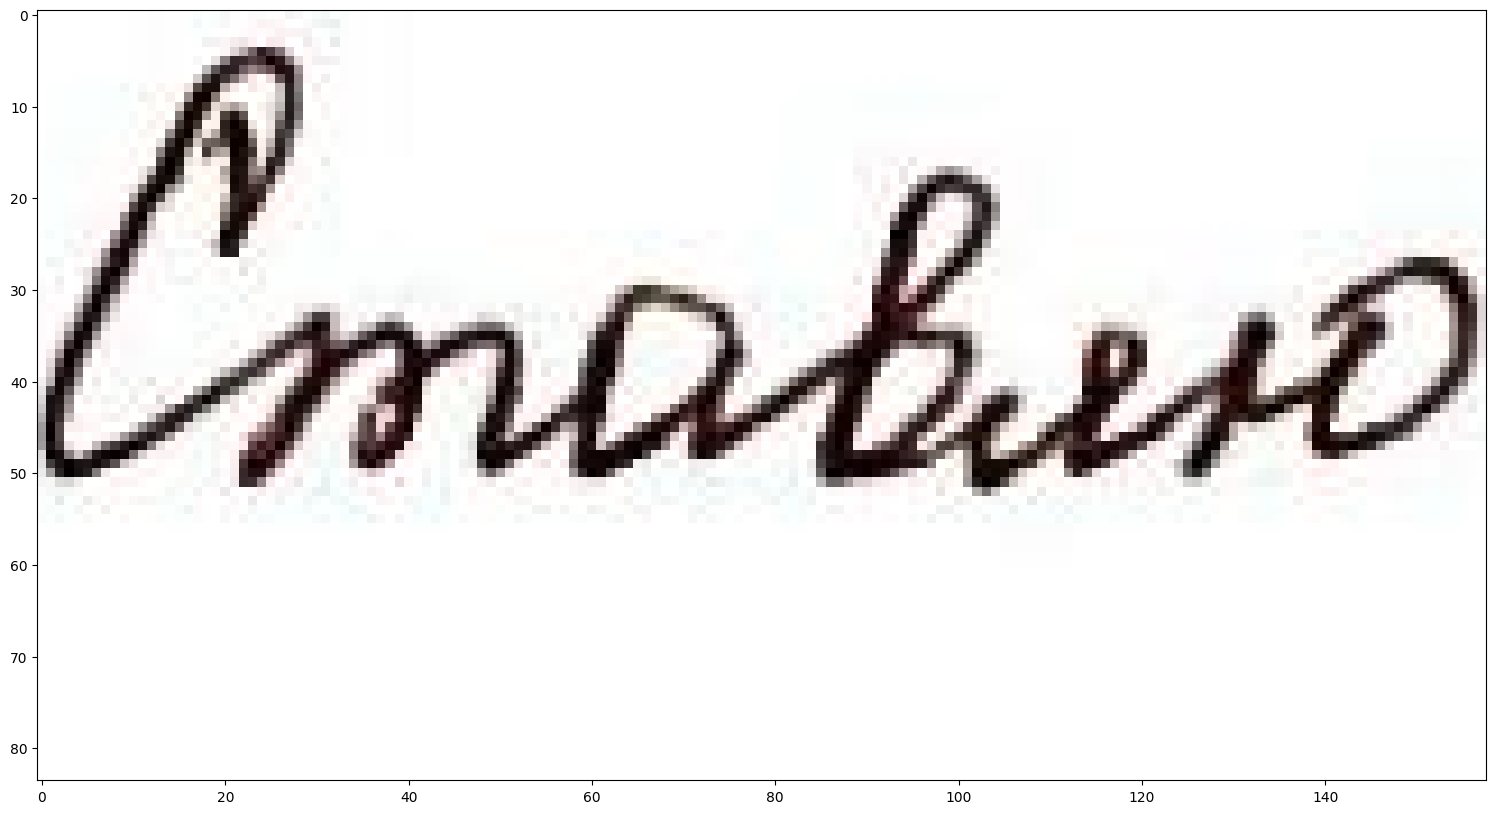

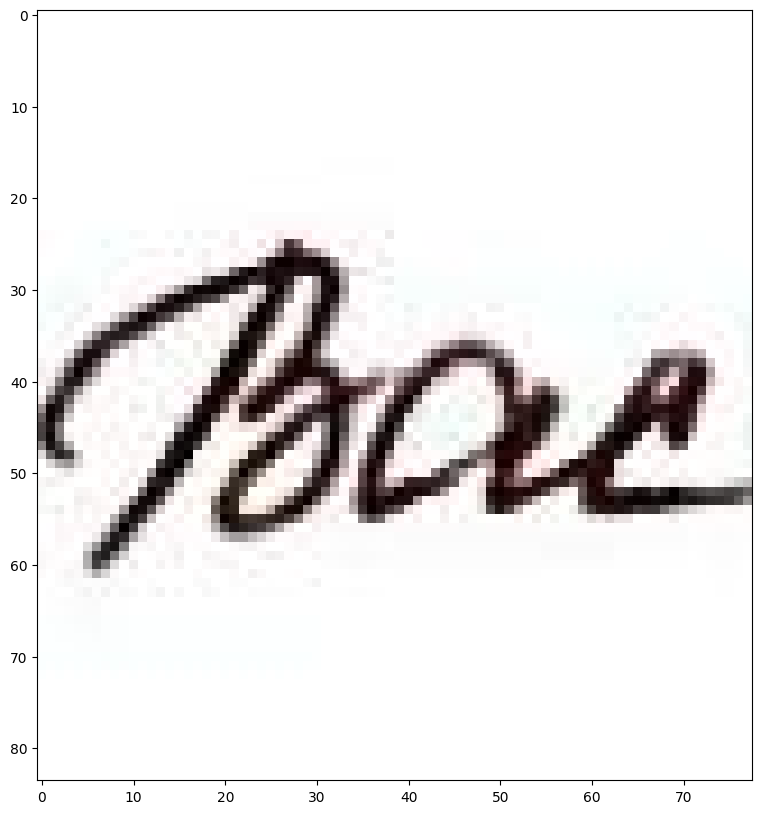

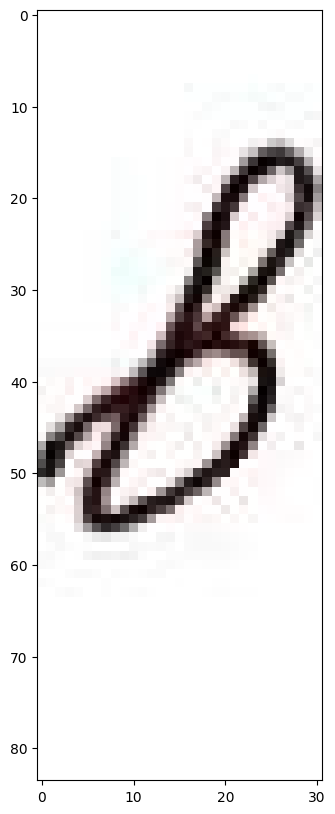

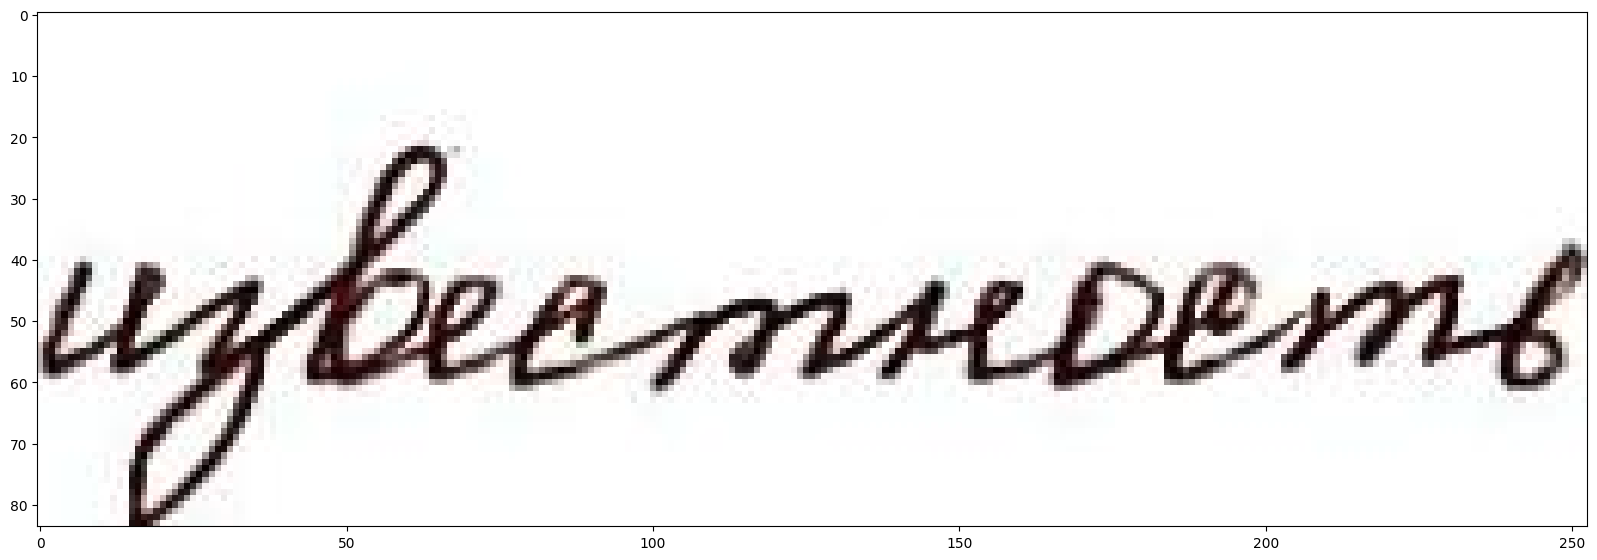

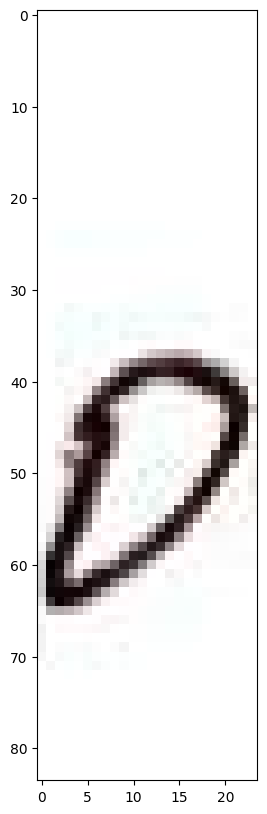

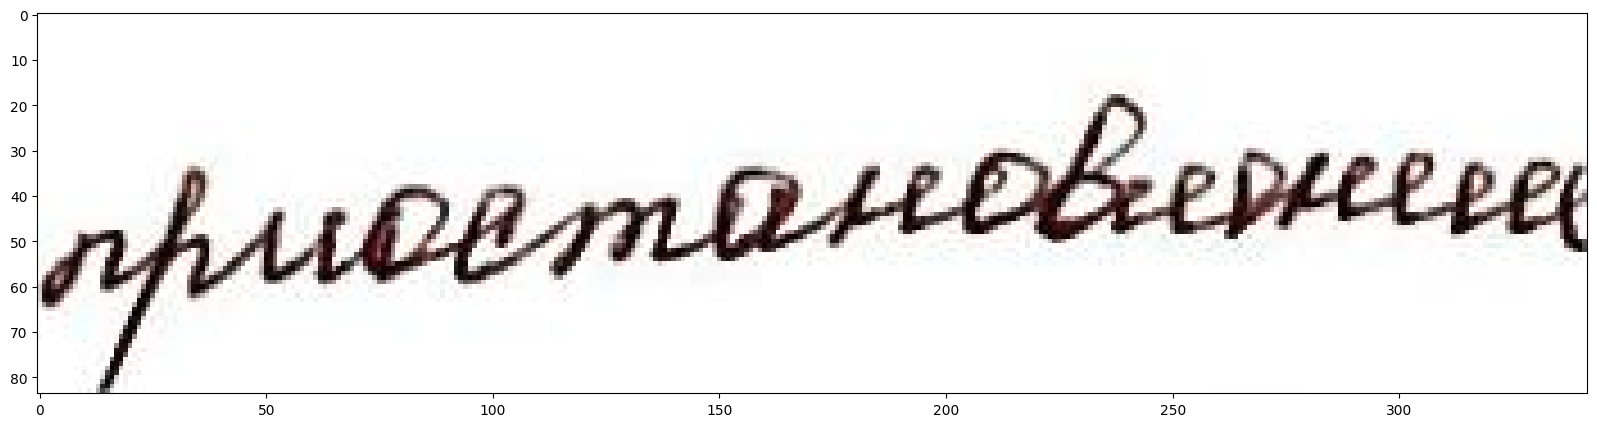

In [82]:
for i in range(1, len(plateaus)):
    show(line[..., plateaus[i - 1][1]: plateaus[i][0], 0:3])

In [149]:
import requests
import secrets
from concurrent.futures import ThreadPoolExecutor

def get_status_code(url):
    response = requests.get(url)
    return response.status_code

def get_url():
    return f"https://api.multiavatar.com/{secrets.token_hex(4)}.png"

num_requests = 500

with ThreadPoolExecutor(max_workers=500) as executor:
    futures = [executor.submit(get_status_code, get_url()) for _ in range(num_requests)]
    results = [future.result() for future in futures]

for result in results:
    print(result)

200
429
200
429
429
200
200
429
429
403
429
429
200
429
403
429
403
429
429
403
429
429
429
429
403
429
200
429
403
200
429
429
403
429
429
429
200
429
429
200
429
429
200
403
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
403
429
429
429
429
429
429
429
429
429
429
429
429
403
403
429
429
429
403
429
429
429
429
429
429
429
429
429
429
429
429
403
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
403
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
403
429
429
429
429
429
429
429
429
403
429
429
429
429
429
429
429
429
429
429
429
403
403
429
429
429
429
429
429
429
403
429
429
429
429
429
403
429
429
429
429
429
429
403
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
403
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
403
429
403
429
429
429
429
429
429
429
429
429
429
429


In [150]:
sorted(results)

[200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 200,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 403,
 429,
 429,
 429,
 429,
 429,
 429,
 429,
 429,
 429